In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import re
import h5py
import math
import shutil
import random
import nibabel
import tarfile
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from nilearn import plotting
from nilearn.plotting import plot_anat, plot_roi
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(filename, os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install einops
!pip install medpy
from einops import rearrange
from medpy import metric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 622.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for medpy: filename=MedPy-0.5.1-py3-none-any.whl size=224731 sha256=0f089663bf695f8be8d71350b107319b99cfe09bc56735a4beace3574a216052
  Stored in directory: /root/.cache/pip/wheels/e6/8f/f9/7fec657d34ad3ebd2ea3ca5ad0e526f8fea93c3fb4a26c3416
Successfully built medpy


### Preset

In [3]:
!mkdir checkpoint
!mkdir results
!mkdir data
!mkdir dataset

In [4]:
# shutil.rmtree('./dataset')

In [5]:
train_set = {
        'root': './data',    # input path to original dataset of 4 labels
        'out': './dataset',  # output path to preprocessed dataset
        'flist': '/kaggle/input/train-list/train.txt',  # training IDs
        }

# remove hidden files to empty the folder
dss = train_set['root'] + '/.DS_Store'
if os.path.exists(dss):
    os.remove(dss)

# if origianal dataset folder is empty, extract the dataset from input
if len(os.listdir(train_set['root'])) == 0 and len(os.listdir(train_set['out'])) == 0:
    zip_file = tarfile.open("/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar")
    zip_file.extractall(train_set['root'])
    zip_file.close()

### Data Preprocessing

In [6]:
# mri images of four modalities
modalities = ('flair', 't1ce', 't1', 't2')

def process_h5(path, out_path):
    """ Save the data with dtype=float32.
        z-score is used but keep the background with zero! """
    if not os.path.exists(path + 'seg.nii.gz'): return

    # SimpleITK reads images in DxHxD by default，convert it to HxWxD here
    label = sitk.GetArrayFromImage(sitk.ReadImage(path + 'seg.nii.gz')).transpose(1,2,0)
    print(label.shape)
    # stack images of four modalities 4 x (H,W,D) -> (4,H,W,D) 
    images = np.stack([sitk.GetArrayFromImage(sitk.ReadImage(path + modal + '.nii.gz')).transpose(1,2,0) for modal in modalities], 0)  # [240,240,155]
    # datatype converting
    label = label.astype(np.uint8)
    images = images.astype(np.float32)
    case_name = path.split('/')[-1]
    # case_name = os.path.split(path)[-1]  # different paths for windows and linux
    
    path = os.path.join(out_path,case_name)
    path_to_rm = os.path.join('./data',case_name)[:-1]
    output = path + 'mri_norm2.h5'
    # print('path_to_rm', path_to_rm)
    if os.path.exists(output):
        shutil.rmtree(path_to_rm)
        return
    
    # sum up the first channel, if all four modalities are 0, mark it as background (False):
    mask = images.sum(0) > 0
    for k in range(4):

        x = images[k,...]  #
        y = x[mask]

        # normalize the region outside the background
        x[mask] -= y.mean()
        x[mask] /= y.std()

        images[k,...] = x
    print(case_name, images.shape, label.shape)
    f = h5py.File(output, 'w')
    f.create_dataset('image', data=images, compression="gzip")
    f.create_dataset('label', data=label, compression="gzip")
    f.close()
    
    # remove the original dataset to save space
    shutil.rmtree(path_to_rm)


def doit(dset):
    root, out_path = dset['root'], dset['out']
    file_list = os.path.join(root, dset['flist'])
    subjects = open(file_list).read().splitlines()
    names = ['BraTS2021_' + sub for sub in subjects]
    names = random.sample(names, 125)
    paths = [os.path.join(root, name, name + '_') for name in names]

    for path in tqdm(paths):
        process_h5(path, out_path)

    print('Finished')

doit(train_set)

  0%|          | 0/125 [00:00<?, ?it/s]

(240, 240, 155)
BraTS2021_01182_ (4, 240, 240, 155) (240, 240, 155)


  1%|          | 1/125 [00:02<05:24,  2.62s/it]

(240, 240, 155)
BraTS2021_01252_ (4, 240, 240, 155) (240, 240, 155)


  2%|▏         | 2/125 [00:04<04:59,  2.44s/it]

(240, 240, 155)
BraTS2021_00284_ (4, 240, 240, 155) (240, 240, 155)


  2%|▏         | 3/125 [00:07<04:57,  2.44s/it]

(240, 240, 155)
BraTS2021_01207_ (4, 240, 240, 155) (240, 240, 155)


  3%|▎         | 4/125 [00:09<04:46,  2.37s/it]

(240, 240, 155)
BraTS2021_01397_ (4, 240, 240, 155) (240, 240, 155)


  4%|▍         | 5/125 [00:11<04:41,  2.35s/it]

(240, 240, 155)
BraTS2021_00478_ (4, 240, 240, 155) (240, 240, 155)


  5%|▍         | 6/125 [00:14<04:45,  2.40s/it]

(240, 240, 155)
BraTS2021_01395_ (4, 240, 240, 155) (240, 240, 155)


  6%|▌         | 7/125 [00:16<04:40,  2.38s/it]

(240, 240, 155)
BraTS2021_01246_ (4, 240, 240, 155) (240, 240, 155)


  6%|▋         | 8/125 [00:19<04:41,  2.41s/it]

(240, 240, 155)
BraTS2021_00360_ (4, 240, 240, 155) (240, 240, 155)


  7%|▋         | 9/125 [00:21<04:37,  2.39s/it]

(240, 240, 155)
BraTS2021_00375_ (4, 240, 240, 155) (240, 240, 155)


  8%|▊         | 10/125 [00:23<04:34,  2.39s/it]

(240, 240, 155)
BraTS2021_01572_ (4, 240, 240, 155) (240, 240, 155)


  9%|▉         | 11/125 [00:27<05:05,  2.68s/it]

(240, 240, 155)
BraTS2021_01181_ (4, 240, 240, 155) (240, 240, 155)


 10%|▉         | 12/125 [00:29<04:49,  2.56s/it]

(240, 240, 155)
BraTS2021_01428_ (4, 240, 240, 155) (240, 240, 155)


 10%|█         | 13/125 [00:31<04:37,  2.48s/it]

(240, 240, 155)
BraTS2021_01412_ (4, 240, 240, 155) (240, 240, 155)


 11%|█         | 14/125 [00:34<04:31,  2.45s/it]

(240, 240, 155)
BraTS2021_00661_ (4, 240, 240, 155) (240, 240, 155)


 12%|█▏        | 15/125 [00:36<04:30,  2.46s/it]

(240, 240, 155)
BraTS2021_00578_ (4, 240, 240, 155) (240, 240, 155)


 13%|█▎        | 16/125 [00:39<04:35,  2.53s/it]

(240, 240, 155)
BraTS2021_00413_ (4, 240, 240, 155) (240, 240, 155)


 14%|█▎        | 17/125 [00:41<04:24,  2.45s/it]

(240, 240, 155)
BraTS2021_01044_ (4, 240, 240, 155) (240, 240, 155)


 14%|█▍        | 18/125 [00:44<04:20,  2.43s/it]

(240, 240, 155)
BraTS2021_00231_ (4, 240, 240, 155) (240, 240, 155)


 15%|█▌        | 19/125 [00:46<04:18,  2.44s/it]

(240, 240, 155)
BraTS2021_01535_ (4, 240, 240, 155) (240, 240, 155)


 16%|█▌        | 20/125 [00:48<04:10,  2.39s/it]

(240, 240, 155)
BraTS2021_00100_ (4, 240, 240, 155) (240, 240, 155)


 17%|█▋        | 21/125 [00:51<04:02,  2.33s/it]

(240, 240, 155)
BraTS2021_01416_ (4, 240, 240, 155) (240, 240, 155)


 18%|█▊        | 22/125 [00:53<03:59,  2.33s/it]

(240, 240, 155)
BraTS2021_00801_ (4, 240, 240, 155) (240, 240, 155)


 18%|█▊        | 23/125 [00:56<04:25,  2.61s/it]

(240, 240, 155)
BraTS2021_01375_ (4, 240, 240, 155) (240, 240, 155)


 19%|█▉        | 24/125 [00:58<04:11,  2.49s/it]

(240, 240, 155)
BraTS2021_01453_ (4, 240, 240, 155) (240, 240, 155)


 20%|██        | 25/125 [01:01<03:59,  2.40s/it]

(240, 240, 155)
BraTS2021_01149_ (4, 240, 240, 155) (240, 240, 155)


 21%|██        | 26/125 [01:03<03:52,  2.35s/it]

(240, 240, 155)
BraTS2021_01015_ (4, 240, 240, 155) (240, 240, 155)


 22%|██▏       | 27/125 [01:05<03:48,  2.34s/it]

(240, 240, 155)
BraTS2021_00657_ (4, 240, 240, 155) (240, 240, 155)


 22%|██▏       | 28/125 [01:08<03:52,  2.40s/it]

(240, 240, 155)
BraTS2021_01169_ (4, 240, 240, 155) (240, 240, 155)


 23%|██▎       | 29/125 [01:10<03:44,  2.34s/it]

(240, 240, 155)
BraTS2021_01080_ (4, 240, 240, 155) (240, 240, 155)


 24%|██▍       | 30/125 [01:12<03:39,  2.31s/it]

(240, 240, 155)
BraTS2021_01328_ (4, 240, 240, 155) (240, 240, 155)


 25%|██▍       | 31/125 [01:14<03:35,  2.29s/it]

(240, 240, 155)
BraTS2021_00680_ (4, 240, 240, 155) (240, 240, 155)


 26%|██▌       | 32/125 [01:17<03:43,  2.41s/it]

(240, 240, 155)
BraTS2021_01122_ (4, 240, 240, 155) (240, 240, 155)


 26%|██▋       | 33/125 [01:19<03:37,  2.36s/it]

(240, 240, 155)
BraTS2021_00558_ (4, 240, 240, 155) (240, 240, 155)


 27%|██▋       | 34/125 [01:22<03:41,  2.43s/it]

(240, 240, 155)
BraTS2021_01265_ (4, 240, 240, 155) (240, 240, 155)


 28%|██▊       | 35/125 [01:24<03:39,  2.44s/it]

(240, 240, 155)
BraTS2021_00054_ (4, 240, 240, 155) (240, 240, 155)


 29%|██▉       | 36/125 [01:27<03:34,  2.41s/it]

(240, 240, 155)
BraTS2021_00327_ (4, 240, 240, 155) (240, 240, 155)


 30%|██▉       | 37/125 [01:29<03:30,  2.39s/it]

(240, 240, 155)
BraTS2021_01458_ (4, 240, 240, 155) (240, 240, 155)


 30%|███       | 38/125 [01:31<03:20,  2.31s/it]

(240, 240, 155)
BraTS2021_00802_ (4, 240, 240, 155) (240, 240, 155)


 31%|███       | 39/125 [01:34<03:41,  2.58s/it]

(240, 240, 155)
BraTS2021_00283_ (4, 240, 240, 155) (240, 240, 155)


 32%|███▏      | 40/125 [01:37<03:36,  2.55s/it]

(240, 240, 155)
BraTS2021_00053_ (4, 240, 240, 155) (240, 240, 155)


 33%|███▎      | 41/125 [01:39<03:38,  2.60s/it]

(240, 240, 155)
BraTS2021_01056_ (4, 240, 240, 155) (240, 240, 155)


 34%|███▎      | 42/125 [01:42<03:28,  2.52s/it]

(240, 240, 155)
BraTS2021_01634_ (4, 240, 240, 155) (240, 240, 155)


 34%|███▍      | 43/125 [01:45<03:51,  2.82s/it]

(240, 240, 155)
BraTS2021_01259_ (4, 240, 240, 155) (240, 240, 155)


 35%|███▌      | 44/125 [01:48<03:36,  2.68s/it]

(240, 240, 155)
BraTS2021_00494_ (4, 240, 240, 155) (240, 240, 155)


 36%|███▌      | 45/125 [01:50<03:29,  2.62s/it]

(240, 240, 155)
BraTS2021_01322_ (4, 240, 240, 155) (240, 240, 155)


 37%|███▋      | 46/125 [01:53<03:20,  2.54s/it]

(240, 240, 155)
BraTS2021_01064_ (4, 240, 240, 155) (240, 240, 155)


 38%|███▊      | 47/125 [01:55<03:14,  2.49s/it]

(240, 240, 155)
BraTS2021_01469_ (4, 240, 240, 155) (240, 240, 155)


 38%|███▊      | 48/125 [01:57<03:05,  2.41s/it]

(240, 240, 155)
BraTS2021_01577_ (4, 240, 240, 155) (240, 240, 155)


 39%|███▉      | 49/125 [02:00<03:24,  2.69s/it]

(240, 240, 155)
BraTS2021_00750_ (4, 240, 240, 155) (240, 240, 155)


 40%|████      | 50/125 [02:03<03:17,  2.64s/it]

(240, 240, 155)
BraTS2021_01003_ (4, 240, 240, 155) (240, 240, 155)


 41%|████      | 51/125 [02:05<03:05,  2.51s/it]

(240, 240, 155)
BraTS2021_00426_ (4, 240, 240, 155) (240, 240, 155)


 42%|████▏     | 52/125 [02:08<02:59,  2.46s/it]

(240, 240, 155)
BraTS2021_01039_ (4, 240, 240, 155) (240, 240, 155)


 42%|████▏     | 53/125 [02:10<02:54,  2.42s/it]

(240, 240, 155)
BraTS2021_00464_ (4, 240, 240, 155) (240, 240, 155)


 43%|████▎     | 54/125 [02:12<02:55,  2.47s/it]

(240, 240, 155)
BraTS2021_01025_ (4, 240, 240, 155) (240, 240, 155)


 44%|████▍     | 55/125 [02:15<02:47,  2.39s/it]

(240, 240, 155)
BraTS2021_01135_ (4, 240, 240, 155) (240, 240, 155)


 45%|████▍     | 56/125 [02:17<02:44,  2.39s/it]

(240, 240, 155)
BraTS2021_00242_ (4, 240, 240, 155) (240, 240, 155)


 46%|████▌     | 57/125 [02:19<02:42,  2.39s/it]

(240, 240, 155)
BraTS2021_00694_ (4, 240, 240, 155) (240, 240, 155)


 46%|████▋     | 58/125 [02:22<02:40,  2.39s/it]

(240, 240, 155)
BraTS2021_01350_ (4, 240, 240, 155) (240, 240, 155)


 47%|████▋     | 59/125 [02:24<02:33,  2.33s/it]

(240, 240, 155)
BraTS2021_01232_ (4, 240, 240, 155) (240, 240, 155)


 48%|████▊     | 60/125 [02:26<02:31,  2.33s/it]

(240, 240, 155)
BraTS2021_00006_ (4, 240, 240, 155) (240, 240, 155)


 49%|████▉     | 61/125 [02:29<02:31,  2.37s/it]

(240, 240, 155)
BraTS2021_00211_ (4, 240, 240, 155) (240, 240, 155)


 50%|████▉     | 62/125 [02:31<02:29,  2.38s/it]

(240, 240, 155)
BraTS2021_01117_ (4, 240, 240, 155) (240, 240, 155)


 50%|█████     | 63/125 [02:34<02:28,  2.40s/it]

(240, 240, 155)
BraTS2021_01068_ (4, 240, 240, 155) (240, 240, 155)


 51%|█████     | 64/125 [02:36<02:26,  2.40s/it]

(240, 240, 155)
BraTS2021_00035_ (4, 240, 240, 155) (240, 240, 155)


 52%|█████▏    | 65/125 [02:38<02:22,  2.38s/it]

(240, 240, 155)
BraTS2021_00341_ (4, 240, 240, 155) (240, 240, 155)


 53%|█████▎    | 66/125 [02:41<02:18,  2.36s/it]

(240, 240, 155)
BraTS2021_00513_ (4, 240, 240, 155) (240, 240, 155)


 54%|█████▎    | 67/125 [02:43<02:20,  2.42s/it]

(240, 240, 155)
BraTS2021_01478_ (4, 240, 240, 155) (240, 240, 155)


 54%|█████▍    | 68/125 [02:45<02:14,  2.36s/it]

(240, 240, 155)
BraTS2021_01134_ (4, 240, 240, 155) (240, 240, 155)


 55%|█████▌    | 69/125 [02:48<02:11,  2.35s/it]

(240, 240, 155)
BraTS2021_01618_ (4, 240, 240, 155) (240, 240, 155)


 56%|█████▌    | 70/125 [02:51<02:23,  2.61s/it]

(240, 240, 155)
BraTS2021_00377_ (4, 240, 240, 155) (240, 240, 155)


 57%|█████▋    | 71/125 [02:53<02:14,  2.50s/it]

(240, 240, 155)
BraTS2021_00246_ (4, 240, 240, 155) (240, 240, 155)


 58%|█████▊    | 72/125 [02:56<02:11,  2.48s/it]

(240, 240, 155)
BraTS2021_01313_ (4, 240, 240, 155) (240, 240, 155)


 58%|█████▊    | 73/125 [02:58<02:06,  2.43s/it]

(240, 240, 155)
BraTS2021_01285_ (4, 240, 240, 155) (240, 240, 155)


 59%|█████▉    | 74/125 [03:00<02:01,  2.37s/it]

(240, 240, 155)
BraTS2021_01222_ (4, 240, 240, 155) (240, 240, 155)


 60%|██████    | 75/125 [03:02<01:55,  2.32s/it]

(240, 240, 155)
BraTS2021_00586_ (4, 240, 240, 155) (240, 240, 155)


 61%|██████    | 76/125 [03:05<02:01,  2.48s/it]

(240, 240, 155)
BraTS2021_01539_ (4, 240, 240, 155) (240, 240, 155)


 62%|██████▏   | 77/125 [03:08<02:08,  2.69s/it]

(240, 240, 155)
BraTS2021_01293_ (4, 240, 240, 155) (240, 240, 155)


 62%|██████▏   | 78/125 [03:11<02:00,  2.57s/it]

(240, 240, 155)
BraTS2021_01597_ (4, 240, 240, 155) (240, 240, 155)


 63%|██████▎   | 79/125 [03:14<02:06,  2.75s/it]

(240, 240, 155)
BraTS2021_01223_ (4, 240, 240, 155) (240, 240, 155)


 64%|██████▍   | 80/125 [03:16<01:58,  2.63s/it]

(240, 240, 155)
BraTS2021_01650_ (4, 240, 240, 155) (240, 240, 155)


 65%|██████▍   | 81/125 [03:20<02:04,  2.82s/it]

(240, 240, 155)
BraTS2021_00130_ (4, 240, 240, 155) (240, 240, 155)


 66%|██████▌   | 82/125 [03:22<01:54,  2.67s/it]

(240, 240, 155)
BraTS2021_00165_ (4, 240, 240, 155) (240, 240, 155)


 66%|██████▋   | 83/125 [03:24<01:48,  2.59s/it]

(240, 240, 155)
BraTS2021_01575_ (4, 240, 240, 155) (240, 240, 155)


 67%|██████▋   | 84/125 [03:28<01:54,  2.80s/it]

(240, 240, 155)
BraTS2021_00217_ (4, 240, 240, 155) (240, 240, 155)


 68%|██████▊   | 85/125 [03:30<01:47,  2.68s/it]

(240, 240, 155)
BraTS2021_01411_ (4, 240, 240, 155) (240, 240, 155)


 69%|██████▉   | 86/125 [03:32<01:40,  2.57s/it]

(240, 240, 155)
BraTS2021_00291_ (4, 240, 240, 155) (240, 240, 155)


 70%|██████▉   | 87/125 [03:35<01:35,  2.52s/it]

(240, 240, 155)
BraTS2021_01040_ (4, 240, 240, 155) (240, 240, 155)


 70%|███████   | 88/125 [03:37<01:32,  2.50s/it]

(240, 240, 155)
BraTS2021_00628_ (4, 240, 240, 155) (240, 240, 155)


 71%|███████   | 89/125 [03:40<01:28,  2.47s/it]

(240, 240, 155)
BraTS2021_00258_ (4, 240, 240, 155) (240, 240, 155)


 72%|███████▏  | 90/125 [03:42<01:23,  2.40s/it]

(240, 240, 155)
BraTS2021_01091_ (4, 240, 240, 155) (240, 240, 155)


 73%|███████▎  | 91/125 [03:44<01:20,  2.38s/it]

(240, 240, 155)
BraTS2021_00517_ (4, 240, 240, 155) (240, 240, 155)


 74%|███████▎  | 92/125 [03:47<01:19,  2.42s/it]

(240, 240, 155)
BraTS2021_00373_ (4, 240, 240, 155) (240, 240, 155)


 74%|███████▍  | 93/125 [03:49<01:16,  2.40s/it]

(240, 240, 155)
BraTS2021_00366_ (4, 240, 240, 155) (240, 240, 155)


 75%|███████▌  | 94/125 [03:51<01:13,  2.38s/it]

(240, 240, 155)
BraTS2021_01495_ (4, 240, 240, 155) (240, 240, 155)


 76%|███████▌  | 95/125 [03:53<01:09,  2.32s/it]

(240, 240, 155)
BraTS2021_01550_ (4, 240, 240, 155) (240, 240, 155)


 77%|███████▋  | 96/125 [03:57<01:15,  2.60s/it]

(240, 240, 155)
BraTS2021_01402_ (4, 240, 240, 155) (240, 240, 155)


 78%|███████▊  | 97/125 [03:59<01:10,  2.51s/it]

(240, 240, 155)
BraTS2021_00454_ (4, 240, 240, 155) (240, 240, 155)


 78%|███████▊  | 98/125 [04:01<01:06,  2.45s/it]

(240, 240, 155)
BraTS2021_00457_ (4, 240, 240, 155) (240, 240, 155)


 79%|███████▉  | 99/125 [04:04<01:02,  2.42s/it]

(240, 240, 155)
BraTS2021_01281_ (4, 240, 240, 155) (240, 240, 155)


 80%|████████  | 100/125 [04:06<00:59,  2.37s/it]

(240, 240, 155)
BraTS2021_00170_ (4, 240, 240, 155) (240, 240, 155)


 81%|████████  | 101/125 [04:08<00:56,  2.34s/it]

(240, 240, 155)
BraTS2021_00727_ (4, 240, 240, 155) (240, 240, 155)


 82%|████████▏ | 102/125 [04:10<00:53,  2.33s/it]

(240, 240, 155)
BraTS2021_00058_ (4, 240, 240, 155) (240, 240, 155)


 82%|████████▏ | 103/125 [04:13<00:51,  2.32s/it]

(240, 240, 155)
BraTS2021_00049_ (4, 240, 240, 155) (240, 240, 155)


 83%|████████▎ | 104/125 [04:15<00:48,  2.32s/it]

(240, 240, 155)
BraTS2021_01245_ (4, 240, 240, 155) (240, 240, 155)


 84%|████████▍ | 105/125 [04:17<00:46,  2.31s/it]

(240, 240, 155)
BraTS2021_01420_ (4, 240, 240, 155) (240, 240, 155)


 85%|████████▍ | 106/125 [04:20<00:44,  2.33s/it]

(240, 240, 155)
BraTS2021_00300_ (4, 240, 240, 155) (240, 240, 155)


 86%|████████▌ | 107/125 [04:22<00:42,  2.38s/it]

(240, 240, 155)
BraTS2021_00443_ (4, 240, 240, 155) (240, 240, 155)


 86%|████████▋ | 108/125 [04:25<00:40,  2.38s/it]

(240, 240, 155)
BraTS2021_00542_ (4, 240, 240, 155) (240, 240, 155)


 87%|████████▋ | 109/125 [04:27<00:38,  2.40s/it]

(240, 240, 155)
BraTS2021_00305_ (4, 240, 240, 155) (240, 240, 155)


 88%|████████▊ | 110/125 [04:29<00:35,  2.36s/it]

(240, 240, 155)
BraTS2021_01470_ (4, 240, 240, 155) (240, 240, 155)


 89%|████████▉ | 111/125 [04:32<00:32,  2.31s/it]

(240, 240, 155)
BraTS2021_00507_ (4, 240, 240, 155) (240, 240, 155)


 90%|████████▉ | 112/125 [04:34<00:30,  2.32s/it]

(240, 240, 155)
BraTS2021_01076_ (4, 240, 240, 155) (240, 240, 155)


 90%|█████████ | 113/125 [04:36<00:27,  2.32s/it]

(240, 240, 155)
BraTS2021_00747_ (4, 240, 240, 155) (240, 240, 155)


 91%|█████████ | 114/125 [04:39<00:25,  2.36s/it]

(240, 240, 155)
BraTS2021_00005_ (4, 240, 240, 155) (240, 240, 155)


 92%|█████████▏| 115/125 [04:41<00:23,  2.36s/it]

(240, 240, 155)
BraTS2021_00554_ (4, 240, 240, 155) (240, 240, 155)


 93%|█████████▎| 116/125 [04:44<00:21,  2.39s/it]

(240, 240, 155)
BraTS2021_00143_ (4, 240, 240, 155) (240, 240, 155)


 94%|█████████▎| 117/125 [04:46<00:18,  2.36s/it]

(240, 240, 155)
BraTS2021_01002_ (4, 240, 240, 155) (240, 240, 155)


 94%|█████████▍| 118/125 [04:48<00:16,  2.31s/it]

(240, 240, 155)
BraTS2021_01218_ (4, 240, 240, 155) (240, 240, 155)


 95%|█████████▌| 119/125 [04:50<00:13,  2.29s/it]

(240, 240, 155)
BraTS2021_00176_ (4, 240, 240, 155) (240, 240, 155)


 96%|█████████▌| 120/125 [04:53<00:11,  2.33s/it]

(240, 240, 155)
BraTS2021_00048_ (4, 240, 240, 155) (240, 240, 155)


 97%|█████████▋| 121/125 [04:55<00:09,  2.38s/it]

(240, 240, 155)
BraTS2021_01203_ (4, 240, 240, 155) (240, 240, 155)


 98%|█████████▊| 122/125 [04:57<00:07,  2.36s/it]

(240, 240, 155)
BraTS2021_00139_ (4, 240, 240, 155) (240, 240, 155)


 98%|█████████▊| 123/125 [05:00<00:04,  2.30s/it]

(240, 240, 155)
BraTS2021_01287_ (4, 240, 240, 155) (240, 240, 155)


 99%|█████████▉| 124/125 [05:02<00:02,  2.31s/it]

(240, 240, 155)
BraTS2021_01347_ (4, 240, 240, 155) (240, 240, 155)


100%|██████████| 125/125 [05:04<00:00,  2.44s/it]

Finished


In [7]:
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used for training.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Training will be on CPU.")
    device = torch.device("cpu")

CUDA is available. GPU will be used for training.


In [8]:
train_and_test_set_ids = os.listdir(train_set['out'])
train_and_test_ids = [i[:15] for i in train_and_test_set_ids]

# randomly select 125 groups of sata from 1251 groups
train_and_test_ids = random.sample(train_and_test_ids, 125)

train_ids, val_test_ids = train_test_split(train_and_test_ids, test_size=0.2,random_state=21)
val_ids, test_ids = train_test_split(val_test_ids, test_size=0.5,random_state=21)
print("Using {} images for training, {} images for validation, {} images for testing.".format(len(train_ids),len(val_ids),len(test_ids)))

train_ids.sort()
val_ids.sort()
test_ids.sort()

with open('./train.txt','w') as f:
    f.write('\n'.join(train_ids))

with open('./valid.txt','w') as f:
    f.write('\n'.join(val_ids))

with open('./test.txt','w') as f:
    f.write('\n'.join(test_ids))

Using 100 images for training, 12 images for validation, 13 images for testing.


### Models

In [9]:
# U-Net
class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        # x = self.sigmoid(x)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch,out_ch):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose3d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch+skip_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        features = [32,64,128,256]

        self.inc = InConv(in_channels, features[0])
        self.down1 = Down(features[0], features[1])
        self.down2 = Down(features[1], features[2])
        self.down3 = Down(features[2], features[3])
        self.down4 = Down(features[3], features[3])

        self.up1 = Up(features[3], features[3], features[2])
        self.up2 = Up(features[2], features[2], features[1])
        self.up3 = Up(features[1], features[1], features[0])
        self.up4 = Up(features[0], features[0], features[0])
        self.outc = OutConv(features[0], num_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [10]:
# Attention U-Net
class AttentionBlock(nn.Module):
    def __init__(self, in_channels_x, in_channels_g, int_channels):
        super(AttentionBlock, self).__init__()
        self.Wx = nn.Sequential(nn.Conv3d(in_channels_x, int_channels, kernel_size=1),
                                nn.BatchNorm3d(int_channels))
        self.Wg = nn.Sequential(nn.Conv3d(in_channels_g, int_channels, kernel_size=1),
                                nn.BatchNorm3d(int_channels))
        self.psi = nn.Sequential(nn.Conv3d(int_channels, 1, kernel_size=1),
                                 nn.BatchNorm3d(1),
                                 nn.Sigmoid())

    def forward(self, x, g):
        # apply the Wx to the skip connection
        x1 = self.Wx(x)
        g1 = self.Wg(g)
        out = self.psi(nn.ReLU(inplace=True)(x1 + g1))
        return out * x


class AttentionUpBlock(nn.Module):
    def __init__(self, in_channels_x, in_channels_g, out_channels):
        super(AttentionUpBlock, self).__init__()
        # self.upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.attention = AttentionBlock(in_channels_x, in_channels_g, in_channels_g)
        self.conv_bn1 = DoubleConv(in_channels_g * 2, out_channels)
        self.conv_bn2 = DoubleConv(out_channels, out_channels)

    def forward(self, x, x_skip):
        # note : x_skip is the skip connection and x is the input from the previous block
        # apply the attention block to the skip connection, using x as context

        x = nn.functional.interpolate(x, x_skip.shape[2:], mode='trilinear', align_corners=False)
        x_attention = self.attention(x_skip, x)

        # stack their channels to feed to both convolution blocks
        x = torch.cat((x_attention, x), dim=1)
        x = self.conv_bn1(x)
        return self.conv_bn2(x)


class AttentionUNet(nn.Module):
    def __init__(self, in_channels, num_classes, feature_scale=4):
        super(AttentionUNet, self).__init__()
        feature = [96, 192, 384, 768, 1280]
        feature = [int(x / feature_scale) for x in feature]

        self.inc = InConv(in_channels, feature[0])
        self.down1 = Down(feature[0], feature[1])  # 48
        self.down2 = Down(feature[1], feature[2])  # 24
        self.down3 = Down(feature[2], feature[3])  # 12
        self.down4 = Down(feature[3], feature[3])  # 6

        self.up1 = AttentionUpBlock(feature[3], feature[3], feature[2])
        self.up2 = AttentionUpBlock(feature[2], feature[2], feature[1])
        self.up3 = AttentionUpBlock(feature[1], feature[1], feature[0])
        self.up4 = AttentionUpBlock(feature[0], feature[0], feature[0])
        self.outc = OutConv(feature[0], num_classes)

    def forward(self, x):
        # with torchsnooper.snoop():
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

### Data Enhancing

In [11]:
class RandomCrop(object):
    """
    Crop randomly the image in a sample
    Args:
    output_size (int): Desired output size
    """

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        (c, w, h, d) = image.shape
        w1 = np.random.randint(0, w - self.output_size[0])
        h1 = np.random.randint(0, h - self.output_size[1])
        d1 = np.random.randint(0, d - self.output_size[2])

        label = label[w1:w1 + self.output_size[0], h1:h1 + self.output_size[1], d1:d1 + self.output_size[2]]
        image = image[:,w1:w1 + self.output_size[0], h1:h1 + self.output_size[1], d1:d1 + self.output_size[2]]
        return {'image': image, 'label': label}


class CenterCrop(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        (c,w, h, d) = image.shape

        w1 = int(round((w - self.output_size[0]) / 2.))
        h1 = int(round((h - self.output_size[1]) / 2.))
        d1 = int(round((d - self.output_size[2]) / 2.))

        label = label[w1:w1 + self.output_size[0], h1:h1 + self.output_size[1], d1:d1 + self.output_size[2]]
        image = image[:,w1:w1 + self.output_size[0], h1:h1 + self.output_size[1], d1:d1 + self.output_size[2]]

        return {'image': image, 'label': label}


class RandomRotFlip(object):
    """
    Crop randomly flip the dataset in a sample
    Args:
    output_size (int): Desired output size
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        k = np.random.randint(0, 4)
        image = np.stack([np.rot90(x,k) for x in image],axis=0)
        label = np.rot90(label, k)
        axis = np.random.randint(1, 4)
        image = np.flip(image, axis=axis).copy()
        label = np.flip(label, axis=axis-1).copy()

        return {'image': image, 'label': label}


def augment_gaussian_noise(data_sample, noise_variance=(0, 0.1)):
    if noise_variance[0] == noise_variance[1]:
        variance = noise_variance[0]
    else:
        variance = random.uniform(noise_variance[0], noise_variance[1])
    data_sample = data_sample + np.random.normal(0.0, variance, size=data_sample.shape)
    return data_sample


class GaussianNoise(object):
    def __init__(self, noise_variance=(0, 0.1), p=0.5):
        self.prob = p
        self.noise_variance = noise_variance

    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        if np.random.uniform() < self.prob:
            image = augment_gaussian_noise(image, self.noise_variance)
        return {'image': image, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return {'image': image, 'label': label}


class BraTS(Dataset):
    def __init__(self,data_path, file_path,transform=None):
        with open(file_path, 'r') as f:
            self.paths = [os.path.join(data_path, x.strip())+'_mri_norm2.h5' for x in f.readlines()]
        self.transform = transform

    def __getitem__(self, item):
        h5f = h5py.File(self.paths[item], 'r')
        image = h5f['image'][:]
        label = h5f['label'][:]
        #[0,1,2,4] -> [0,1,2,3]
        label[label == 4] = 3
        # print(image.shape)
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample['image'], sample['label']

    def __len__(self):
        return len(self.paths)

    def collate(self, batch):
        return [torch.cat(v) for v in zip(*batch)]

### Loss and Evaluation Metrics

In [12]:
def Dice(output, target, eps=1e-3):
    inter = torch.sum(output * target,dim=(1,2,-1)) + eps
    union = torch.sum(output,dim=(1,2,-1)) + torch.sum(target,dim=(1,2,-1)) + eps * 2
    x = 2 * inter / union
    dice = torch.mean(x)
    return dice


def cal_dice(output, target):
    '''
    output: (b, num_class, d, h, w)  target: (b, d, h, w)
    dice1(ET):label4
    dice2(TC):label1 + label4
    dice3(WT): label1 + label2 + label4
    Note: label 4 has been replaced with 3
    '''
    output = torch.argmax(output,dim=1)
    dice1 = Dice((output == 3).float(), (target == 3).float())
    dice2 = Dice(((output == 1) | (output == 3)).float(), ((target == 1) | (target == 3)).float())
    dice3 = Dice((output != 0).float(), (target != 0).float())

    return dice1, dice2, dice3


class Loss(nn.Module):
    def __init__(self, n_classes, weight=None, alpha=0.5):
        "dice_loss_plus_cetr_weighted"
        super(Loss, self).__init__()
        self.n_classes = n_classes
        self.weight = weight.cuda()
        # self.weight = weight
        self.alpha = alpha

    def forward(self, input, target):
        # print(torch.unique(target))
        smooth = 0.01

        input1 = F.softmax(input, dim=1)
        target1 = F.one_hot(target,self.n_classes)
        input1 = rearrange(input1,'b n h w s -> b n (h w s)')
        target1 = rearrange(target1,'b h w s n -> b n (h w s)')

        input1 = input1[:, 1:, :]
        target1 = target1[:, 1:, :].float()

        # Calculate loss and dice loss on a batch basis, providing more stable training
        inter = torch.sum(input1 * target1)
        union = torch.sum(input1) + torch.sum(target1) + smooth
        dice = 2.0 * inter / union

        loss = F.cross_entropy(input,target, weight=self.weight)

        total_loss = (1 - self.alpha) * loss + (1 - dice) * self.alpha

        return total_loss

### Training

In [13]:
# The learning rate is updated at each iteration, not just at each epoch.
# Access the learning rate schedule at the current iteration index (scheduler[iter]).
# Update the learning rate for the optimizer's parameter group.
# help the model converge more smoothly and potentially achieve better performance.
def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0.):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule


def train_loop(model,optimizer,scheduler,criterion,train_loader,device,epoch):
    model.train()
    running_loss = 0
    dice1_train = 0
    dice2_train = 0
    dice3_train = 0
    pbar = tqdm(train_loader)
    for it,(images,masks) in enumerate(pbar):
        # update learning rate according to the schedule
        it = len(train_loader) * epoch + it
        param_group = optimizer.param_groups[0]
        param_group['lr'] = scheduler[it]
        # print(scheduler[it])

        # [b,4,128,128,128] , [b,128,128,128]
        images, masks = images.to(device),masks.to(device)
        # [b,4,128,128,128], 4 segmentations
        outputs = model(images)
        # outputs = torch.softmax(outputs,dim=1)
        loss = criterion(outputs, masks)
        dice1, dice2, dice3 = cal_dice(outputs,masks)
        pbar.desc = "loss: {:.3f} ".format(loss.item())

        running_loss += loss.item()
        dice1_train += dice1.item()
        dice2_train += dice2.item()
        dice3_train += dice3.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = running_loss / len(train_loader)
    dice1 = dice1_train / len(train_loader)
    dice2 = dice2_train / len(train_loader)
    dice3 = dice3_train / len(train_loader)
    return {'loss':loss,'dice1':dice1,'dice2':dice2,'dice3':dice3}


def val_loop(model,criterion,val_loader,device):
    model.eval()
    running_loss = 0
    dice1_val = 0
    dice2_val = 0
    dice3_val = 0
    pbar = tqdm(val_loader)
    with torch.no_grad():
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # outputs = torch.softmax(outputs,dim=1)

            loss = criterion(outputs, masks)
            dice1, dice2, dice3 = cal_dice(outputs, masks)

            running_loss += loss.item()
            dice1_val += dice1.item()
            dice2_val += dice2.item()
            dice3_val += dice3.item()
            # pbar.desc = "loss:{:.3f} dice1:{:.3f} dice2:{:.3f} dice3:{:.3f} ".format(loss,dice1,dice2,dice3)

    loss = running_loss / len(val_loader)
    dice1 = dice1_val / len(val_loader)
    dice2 = dice2_val / len(val_loader)
    dice3 = dice3_val / len(val_loader)
    return {'loss':loss,'dice1':dice1,'dice2':dice2,'dice3':dice3}


def train(model,optimizer,scheduler,criterion,train_loader,
          val_loader,epochs,device,train_log,valid_loss_min=999.0):
    train_metrics_all = []
    val_metrics_all = []
    for e in range(epochs):
        # train for epoch
        train_metrics = train_loop(model,optimizer,scheduler,criterion,train_loader,device,e)
        train_metrics_all.append(train_metrics)
        # eval for epoch
        val_metrics = val_loop(model,criterion,val_loader,device)
        val_metrics_all.append(val_metrics)
        info1 = "Epoch:[{}/{}] valid_loss_min: {:.3f} train_loss: {:.3f} valid_loss: {:.3f} ".format(e+1,epochs,valid_loss_min,train_metrics["loss"],val_metrics["loss"])
        info2 = "Train--ET: {:.3f} TC: {:.3f} WT: {:.3f} ".format(train_metrics['dice1'],train_metrics['dice2'],train_metrics['dice3'])
        info3 = "Valid--ET: {:.3f} TC: {:.3f} WT: {:.3f} ".format(val_metrics['dice1'],val_metrics['dice2'],val_metrics['dice3'])
        print(info1)
        print(info2)
        print(info3)
        with open(train_log,'a') as f:
            f.write(info1 + '\n' + info2 + ' ' + info3 + '\n')

        if not os.path.exists(args.save_path):
            os.makedirs(args.save_path)
        save_file = {"model": model.state_dict(),
                     "optimizer": optimizer.state_dict()}
        if val_metrics['loss'] < valid_loss_min:
            valid_loss_min = val_metrics['loss']
            torch.save(save_file, args.weights)
        else:
            torch.save(save_file,os.path.join(args.save_path,'checkpoint{}.pth'.format(e+1)))
    print("Finished Training!")
    return train_metrics_all, val_metrics_all


def main(args):
    torch.manual_seed(args.seed)  # Set the seed for the CPU to ensure reproducible results
    torch.cuda.manual_seed_all(args.seed)  # Set the seed for all GPUs to ensure reproducible results

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # get datasets
    patch_size = (160,160,128)
    train_dataset = BraTS(args.data_path,args.train_txt,transform=transforms.Compose([
        RandomRotFlip(), 
        RandomCrop(patch_size), 
        GaussianNoise(p=0.1), 
        ToTensor()
    ]))
    val_dataset = BraTS(args.data_path,args.valid_txt,transform=transforms.Compose([
        CenterCrop(patch_size),
        ToTensor()
    ]))
    test_dataset = BraTS(args.data_path,args.test_txt,transform=transforms.Compose([
        CenterCrop(patch_size),
        ToTensor()
    ]))
    # a glance at dataset
    # d1 = test_dataset[0]
    # image,label = d1
    # print(image.shape)
    # print(label.shape)
    # print(np.unique(label))

    # data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, num_workers=12,   # num_worker=4
                              shuffle=True, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, num_workers=12, shuffle=False,
                            pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, num_workers=12, shuffle=False,
                             pin_memory=True)

    print("using {} device.".format(device))
    print("using {} images for training, {} images for validation.".format(len(train_dataset), len(val_dataset)))
    # img,label = train_dataset[0]
    # 1 - Necrotic tumor core (NT), 2 - Peritumoral edema (ED), 4 - Enhancing tumor (ET)
    # Evaluation metrics: ET (label 4), TC (label 1 + label 4), WT (label 1 + label 2 + label 4)
    if args.model == 'unet':
        model = UNet(in_channels=4,num_classes=4)
    else:
        model = AttentionUNet(in_channels=4, num_classes=4)
    # Use DataParallel for multi-GPU
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    
    num_params = 0
    for param in model.parameters():
        num_params += param.numel()
    print(f'Total number of parameters: {num_params / 1e6:.3f} M')

    criterion = Loss(n_classes=4, weight=torch.tensor([0.2, 0.3, 0.25, 0.25])).to(device)
    optimizer = optim.SGD(model.parameters(),momentum=0.9, lr=0, weight_decay=5e-4)
    scheduler = cosine_scheduler(base_value=args.lr,final_value=args.min_lr,epochs=args.epochs,
                                 niter_per_ep=len(train_loader),warmup_epochs=args.warmup_epochs,start_warmup_value=5e-4)

    # load training model
    if os.path.exists(args.weights):
        weight_dict = torch.load(args.weights, map_location=device)
        model.load_state_dict(weight_dict['model'])
        optimizer.load_state_dict(weight_dict['optimizer'])
        print('Successfully loading checkpoint.')

    train_metrics_all, val_metrics_all = train(model,optimizer,scheduler,criterion,train_loader,val_loader,args.epochs,device,train_log=args.train_log)

    # metrics1 = val_loop(model, criterion, train_loader, device)
    metrics2 = val_loop(model, criterion, val_loader, device)
    metrics3 = val_loop(model, criterion, test_loader, device)

    # Finally, evaluate all the data again. 
    # Note that the model parameters used here are from the end of the training
    # print("Train -- loss: {:.3f} ET: {:.3f} TC: {:.3f} WT: {:.3f}".format(metrics1['loss'], metrics1['dice1'],metrics1['dice2'], metrics1['dice3']))
    print("Valid -- loss: {:.3f} ET: {:.3f} TC: {:.3f} WT: {:.3f}".format(metrics2['loss'], metrics2['dice1'], metrics2['dice2'], metrics2['dice3']))
    print("Test  -- loss: {:.3f} ET: {:.3f} TC: {:.3f} WT: {:.3f}".format(metrics3['loss'], metrics3['dice1'], metrics3['dice2'], metrics3['dice3']))

    return train_metrics_all, val_metrics_all

In [14]:
class Config:
    def __init__(self):
        self.num_classes = 4
        self.seed = 21
        self.epochs = 60
        self.warmup_epochs = 10
        self.batch_size = 1
        self.lr = 0.004
        self.min_lr = 0.001
        self.data_path = train_set['out']
        self.train_txt = './train.txt'
        self.valid_txt = './valid.txt'
        self.test_txt = './test.txt'
        self.train_log = './results/UNet.txt'
        self.weights = './results/UNet.pth'
        self.save_path = './checkpoint/UNet'
        self.model = 'aunet'  # unet or aunet

args = Config()

In [15]:
if os.path.isfile('./results/UNet.pth'):
    os.remove('./results/UNet.pth')
if os.path.isfile('./results/UNet.txt'):
    os.remove('./results/UNet.txt')

import gc
gc.collect()
torch.cuda.empty_cache()

train_metrics_all, val_metrics_all = main(args)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


using cuda device.
using 100 images for training, 12 images for validation.
Total number of parameters: 6.438 M


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[1/60] valid_loss_min: 999.000 train_loss: 1.026 valid_loss: 0.806 
Train--ET: 0.006 TC: 0.044 WT: 0.334 
Valid--ET: 0.000 TC: 0.029 WT: 0.752 


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Epoch:[2/60] valid_loss_min: 0.806 train_loss: 0.690 valid_loss: 0.620 
Train--ET: 0.010 TC: 0.012 WT: 0.698 
Valid--ET: 0.083 TC: 0.084 WT: 0.763 


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Epoch:[3/60] valid_loss_min: 0.620 train_loss: 0.536 valid_loss: 0.477 
Train--ET: 0.032 TC: 0.071 WT: 0.718 
Valid--ET: 0.396 TC: 0.559 WT: 0.774 


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch:[4/60] valid_loss_min: 0.477 train_loss: 0.428 valid_loss: 0.385 
Train--ET: 0.264 TC: 0.393 WT: 0.741 
Valid--ET: 0.384 TC: 0.378 WT: 0.887 


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch:[5/60] valid_loss_min: 0.385 train_loss: 0.332 valid_loss: 0.274 
Train--ET: 0.526 TC: 0.580 WT: 0.776 
Valid--ET: 0.761 TC: 0.848 WT: 0.816 


100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Epoch:[6/60] valid_loss_min: 0.274 train_loss: 0.296 valid_loss: 0.228 
Train--ET: 0.534 TC: 0.567 WT: 0.771 
Valid--ET: 0.669 TC: 0.713 WT: 0.879 


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch:[7/60] valid_loss_min: 0.228 train_loss: 0.261 valid_loss: 0.314 
Train--ET: 0.623 TC: 0.621 WT: 0.786 
Valid--ET: 0.617 TC: 0.570 WT: 0.632 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[8/60] valid_loss_min: 0.228 train_loss: 0.244 valid_loss: 0.206 
Train--ET: 0.632 TC: 0.610 WT: 0.786 
Valid--ET: 0.688 TC: 0.702 WT: 0.845 


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Epoch:[9/60] valid_loss_min: 0.206 train_loss: 0.240 valid_loss: 0.174 
Train--ET: 0.637 TC: 0.607 WT: 0.790 
Valid--ET: 0.693 TC: 0.711 WT: 0.909 


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Epoch:[10/60] valid_loss_min: 0.174 train_loss: 0.227 valid_loss: 0.201 
Train--ET: 0.659 TC: 0.627 WT: 0.802 
Valid--ET: 0.691 TC: 0.727 WT: 0.825 


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch:[11/60] valid_loss_min: 0.174 train_loss: 0.242 valid_loss: 0.193 
Train--ET: 0.637 TC: 0.610 WT: 0.765 
Valid--ET: 0.710 TC: 0.693 WT: 0.839 


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Epoch:[12/60] valid_loss_min: 0.174 train_loss: 0.219 valid_loss: 0.162 
Train--ET: 0.670 TC: 0.632 WT: 0.816 
Valid--ET: 0.809 TC: 0.796 WT: 0.896 


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Epoch:[13/60] valid_loss_min: 0.162 train_loss: 0.205 valid_loss: 0.169 
Train--ET: 0.702 TC: 0.675 WT: 0.825 
Valid--ET: 0.741 TC: 0.718 WT: 0.888 


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Epoch:[14/60] valid_loss_min: 0.162 train_loss: 0.204 valid_loss: 0.191 
Train--ET: 0.698 TC: 0.693 WT: 0.818 
Valid--ET: 0.788 TC: 0.692 WT: 0.811 


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch:[15/60] valid_loss_min: 0.162 train_loss: 0.203 valid_loss: 0.156 
Train--ET: 0.685 TC: 0.666 WT: 0.826 
Valid--ET: 0.710 TC: 0.688 WT: 0.912 


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Epoch:[16/60] valid_loss_min: 0.156 train_loss: 0.191 valid_loss: 0.186 
Train--ET: 0.690 TC: 0.676 WT: 0.840 
Valid--ET: 0.709 TC: 0.707 WT: 0.827 


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch:[17/60] valid_loss_min: 0.156 train_loss: 0.184 valid_loss: 0.128 
Train--ET: 0.702 TC: 0.705 WT: 0.841 
Valid--ET: 0.846 TC: 0.790 WT: 0.910 


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch:[18/60] valid_loss_min: 0.128 train_loss: 0.180 valid_loss: 0.130 
Train--ET: 0.700 TC: 0.708 WT: 0.842 
Valid--ET: 0.837 TC: 0.832 WT: 0.890 


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch:[19/60] valid_loss_min: 0.128 train_loss: 0.166 valid_loss: 0.165 
Train--ET: 0.732 TC: 0.747 WT: 0.866 
Valid--ET: 0.810 TC: 0.711 WT: 0.859 


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch:[20/60] valid_loss_min: 0.128 train_loss: 0.190 valid_loss: 0.221 
Train--ET: 0.700 TC: 0.682 WT: 0.840 
Valid--ET: 0.780 TC: 0.799 WT: 0.717 


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch:[21/60] valid_loss_min: 0.128 train_loss: 0.190 valid_loss: 0.152 
Train--ET: 0.714 TC: 0.688 WT: 0.825 
Valid--ET: 0.709 TC: 0.718 WT: 0.890 


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch:[22/60] valid_loss_min: 0.128 train_loss: 0.177 valid_loss: 0.121 
Train--ET: 0.707 TC: 0.712 WT: 0.844 
Valid--ET: 0.756 TC: 0.779 WT: 0.905 


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Epoch:[23/60] valid_loss_min: 0.121 train_loss: 0.175 valid_loss: 0.229 
Train--ET: 0.726 TC: 0.735 WT: 0.849 
Valid--ET: 0.847 TC: 0.828 WT: 0.747 


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Epoch:[24/60] valid_loss_min: 0.121 train_loss: 0.200 valid_loss: 0.192 
Train--ET: 0.725 TC: 0.727 WT: 0.795 
Valid--ET: 0.666 TC: 0.664 WT: 0.785 


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Epoch:[25/60] valid_loss_min: 0.121 train_loss: 0.165 valid_loss: 0.157 
Train--ET: 0.745 TC: 0.766 WT: 0.849 
Valid--ET: 0.844 TC: 0.833 WT: 0.856 


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch:[26/60] valid_loss_min: 0.121 train_loss: 0.158 valid_loss: 0.163 
Train--ET: 0.733 TC: 0.752 WT: 0.859 
Valid--ET: 0.747 TC: 0.769 WT: 0.824 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[27/60] valid_loss_min: 0.121 train_loss: 0.148 valid_loss: 0.098 
Train--ET: 0.754 TC: 0.780 WT: 0.874 
Valid--ET: 0.784 TC: 0.808 WT: 0.925 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[28/60] valid_loss_min: 0.098 train_loss: 0.146 valid_loss: 0.117 
Train--ET: 0.755 TC: 0.762 WT: 0.871 
Valid--ET: 0.849 TC: 0.815 WT: 0.923 


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Epoch:[29/60] valid_loss_min: 0.098 train_loss: 0.155 valid_loss: 0.123 
Train--ET: 0.736 TC: 0.751 WT: 0.856 
Valid--ET: 0.788 TC: 0.766 WT: 0.913 


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch:[30/60] valid_loss_min: 0.098 train_loss: 0.147 valid_loss: 0.089 
Train--ET: 0.741 TC: 0.764 WT: 0.870 
Valid--ET: 0.798 TC: 0.823 WT: 0.932 


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch:[31/60] valid_loss_min: 0.089 train_loss: 0.135 valid_loss: 0.107 
Train--ET: 0.768 TC: 0.804 WT: 0.885 
Valid--ET: 0.866 TC: 0.922 WT: 0.907 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[32/60] valid_loss_min: 0.089 train_loss: 0.135 valid_loss: 0.087 
Train--ET: 0.769 TC: 0.803 WT: 0.880 
Valid--ET: 0.808 TC: 0.843 WT: 0.918 


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch:[33/60] valid_loss_min: 0.087 train_loss: 0.127 valid_loss: 0.088 
Train--ET: 0.771 TC: 0.805 WT: 0.888 
Valid--ET: 0.805 TC: 0.835 WT: 0.926 


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Epoch:[34/60] valid_loss_min: 0.087 train_loss: 0.134 valid_loss: 0.080 
Train--ET: 0.768 TC: 0.799 WT: 0.884 
Valid--ET: 0.882 TC: 0.920 WT: 0.937 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[35/60] valid_loss_min: 0.080 train_loss: 0.136 valid_loss: 0.111 
Train--ET: 0.777 TC: 0.798 WT: 0.876 
Valid--ET: 0.748 TC: 0.748 WT: 0.908 


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch:[36/60] valid_loss_min: 0.080 train_loss: 0.132 valid_loss: 0.116 
Train--ET: 0.764 TC: 0.801 WT: 0.886 
Valid--ET: 0.859 TC: 0.873 WT: 0.902 


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch:[37/60] valid_loss_min: 0.080 train_loss: 0.129 valid_loss: 0.090 
Train--ET: 0.772 TC: 0.804 WT: 0.886 
Valid--ET: 0.866 TC: 0.886 WT: 0.928 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[38/60] valid_loss_min: 0.080 train_loss: 0.125 valid_loss: 0.096 
Train--ET: 0.780 TC: 0.816 WT: 0.892 
Valid--ET: 0.879 TC: 0.903 WT: 0.914 


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch:[39/60] valid_loss_min: 0.080 train_loss: 0.126 valid_loss: 0.085 
Train--ET: 0.770 TC: 0.801 WT: 0.891 
Valid--ET: 0.780 TC: 0.810 WT: 0.926 


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Epoch:[40/60] valid_loss_min: 0.080 train_loss: 0.124 valid_loss: 0.088 
Train--ET: 0.773 TC: 0.808 WT: 0.888 
Valid--ET: 0.788 TC: 0.813 WT: 0.928 


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch:[41/60] valid_loss_min: 0.080 train_loss: 0.120 valid_loss: 0.153 
Train--ET: 0.784 TC: 0.821 WT: 0.893 
Valid--ET: 0.845 TC: 0.878 WT: 0.806 


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch:[42/60] valid_loss_min: 0.080 train_loss: 0.119 valid_loss: 0.078 
Train--ET: 0.780 TC: 0.833 WT: 0.888 
Valid--ET: 0.810 TC: 0.842 WT: 0.933 


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Epoch:[43/60] valid_loss_min: 0.078 train_loss: 0.109 valid_loss: 0.077 
Train--ET: 0.793 TC: 0.848 WT: 0.904 
Valid--ET: 0.813 TC: 0.842 WT: 0.934 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[44/60] valid_loss_min: 0.077 train_loss: 0.113 valid_loss: 0.082 
Train--ET: 0.791 TC: 0.847 WT: 0.896 
Valid--ET: 0.823 TC: 0.848 WT: 0.922 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[45/60] valid_loss_min: 0.077 train_loss: 0.108 valid_loss: 0.086 
Train--ET: 0.791 TC: 0.850 WT: 0.901 
Valid--ET: 0.894 TC: 0.917 WT: 0.923 


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Epoch:[46/60] valid_loss_min: 0.077 train_loss: 0.107 valid_loss: 0.101 
Train--ET: 0.791 TC: 0.845 WT: 0.906 
Valid--ET: 0.892 TC: 0.837 WT: 0.906 


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Epoch:[47/60] valid_loss_min: 0.077 train_loss: 0.109 valid_loss: 0.075 
Train--ET: 0.796 TC: 0.846 WT: 0.901 
Valid--ET: 0.812 TC: 0.840 WT: 0.937 


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Epoch:[48/60] valid_loss_min: 0.075 train_loss: 0.111 valid_loss: 0.075 
Train--ET: 0.796 TC: 0.842 WT: 0.903 
Valid--ET: 0.901 TC: 0.930 WT: 0.931 


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch:[49/60] valid_loss_min: 0.075 train_loss: 0.112 valid_loss: 0.075 
Train--ET: 0.790 TC: 0.834 WT: 0.895 
Valid--ET: 0.816 TC: 0.836 WT: 0.940 


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Epoch:[50/60] valid_loss_min: 0.075 train_loss: 0.104 valid_loss: 0.074 
Train--ET: 0.797 TC: 0.853 WT: 0.906 
Valid--ET: 0.815 TC: 0.847 WT: 0.935 


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch:[51/60] valid_loss_min: 0.074 train_loss: 0.110 valid_loss: 0.078 
Train--ET: 0.779 TC: 0.843 WT: 0.900 
Valid--ET: 0.875 TC: 0.908 WT: 0.934 


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch:[52/60] valid_loss_min: 0.074 train_loss: 0.106 valid_loss: 0.077 
Train--ET: 0.795 TC: 0.851 WT: 0.903 
Valid--ET: 0.815 TC: 0.847 WT: 0.936 


100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


Epoch:[53/60] valid_loss_min: 0.074 train_loss: 0.108 valid_loss: 0.081 
Train--ET: 0.800 TC: 0.853 WT: 0.901 
Valid--ET: 0.808 TC: 0.829 WT: 0.933 


100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Epoch:[54/60] valid_loss_min: 0.074 train_loss: 0.105 valid_loss: 0.076 
Train--ET: 0.805 TC: 0.859 WT: 0.907 
Valid--ET: 0.820 TC: 0.845 WT: 0.931 


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch:[55/60] valid_loss_min: 0.074 train_loss: 0.104 valid_loss: 0.080 
Train--ET: 0.807 TC: 0.864 WT: 0.909 
Valid--ET: 0.816 TC: 0.843 WT: 0.925 


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Epoch:[56/60] valid_loss_min: 0.074 train_loss: 0.097 valid_loss: 0.080 
Train--ET: 0.799 TC: 0.863 WT: 0.912 
Valid--ET: 0.908 TC: 0.934 WT: 0.922 


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch:[57/60] valid_loss_min: 0.074 train_loss: 0.101 valid_loss: 0.074 
Train--ET: 0.808 TC: 0.864 WT: 0.911 
Valid--ET: 0.823 TC: 0.851 WT: 0.933 


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch:[58/60] valid_loss_min: 0.074 train_loss: 0.102 valid_loss: 0.069 
Train--ET: 0.799 TC: 0.853 WT: 0.905 
Valid--ET: 0.809 TC: 0.838 WT: 0.941 


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Epoch:[59/60] valid_loss_min: 0.069 train_loss: 0.098 valid_loss: 0.080 
Train--ET: 0.813 TC: 0.874 WT: 0.910 
Valid--ET: 0.822 TC: 0.848 WT: 0.924 


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Epoch:[60/60] valid_loss_min: 0.069 train_loss: 0.096 valid_loss: 0.072 
Train--ET: 0.813 TC: 0.876 WT: 0.914 
Valid--ET: 0.803 TC: 0.834 WT: 0.939 
Finished Training!


100%|██████████| 13/13 [00:10<00:00,  1.27it/s]

Valid -- loss: 0.072 ET: 0.803 TC: 0.834 WT: 0.939
Test  -- loss: 0.148 ET: 0.755 TC: 0.797 WT: 0.882


### Plot

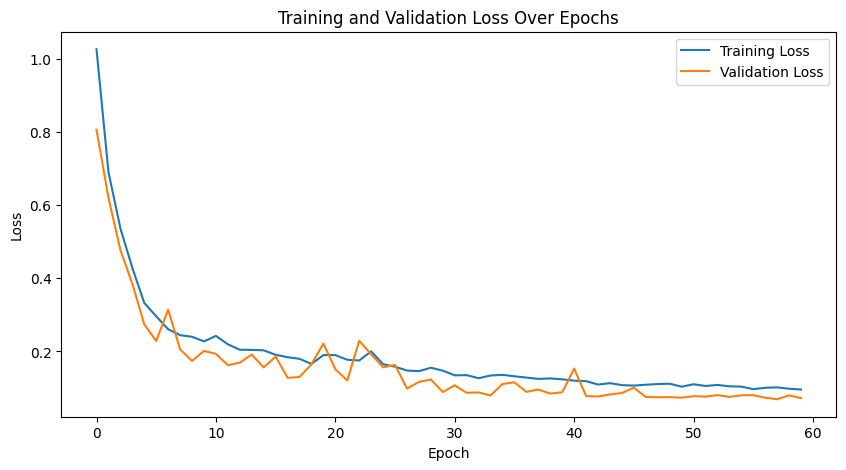

In [16]:
train_losses = [entry['loss'] for entry in train_metrics_all]
valid_losses = [entry['loss'] for entry in val_metrics_all]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.show()

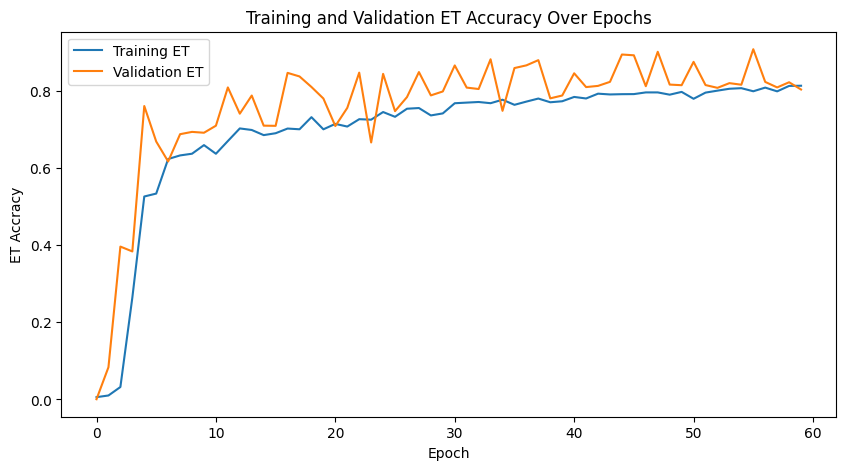

In [17]:
train_et = [entry['dice1'] for entry in train_metrics_all]
val_et = [entry['dice1'] for entry in val_metrics_all]

plt.figure(figsize=(10, 5))
plt.plot(train_et, label='Training ET')
plt.plot(val_et, label='Validation ET')

plt.xlabel('Epoch')
plt.ylabel('ET Accracy')
plt.title('Training and Validation ET Accuracy Over Epochs')
plt.legend()

plt.show()

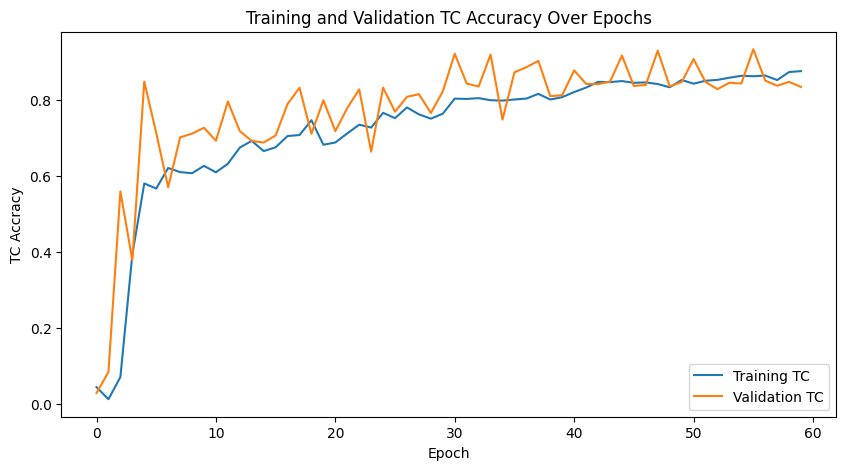

In [18]:
train_tc = [entry['dice2'] for entry in train_metrics_all]
val_tc = [entry['dice2'] for entry in val_metrics_all]

plt.figure(figsize=(10, 5))
plt.plot(train_tc, label='Training TC')
plt.plot(val_tc, label='Validation TC')

plt.xlabel('Epoch')
plt.ylabel('TC Accracy')
plt.title('Training and Validation TC Accuracy Over Epochs')
plt.legend()

plt.show()

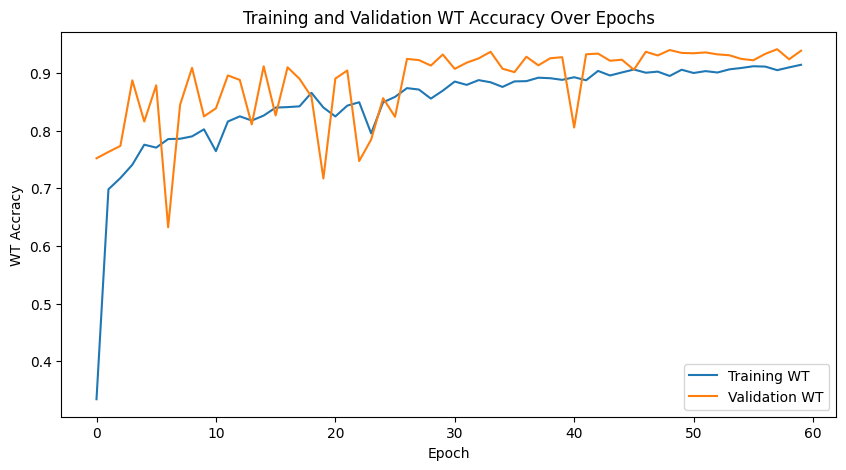

In [19]:
train_wt = [entry['dice3'] for entry in train_metrics_all]
val_wt = [entry['dice3'] for entry in val_metrics_all]

plt.figure(figsize=(10, 5))
plt.plot(train_wt, label='Training WT')
plt.plot(val_wt, label='Validation WT')

plt.xlabel('Epoch')
plt.ylabel('WT Accracy')
plt.title('Training and Validation WT Accuracy Over Epochs')
plt.legend()

plt.show()

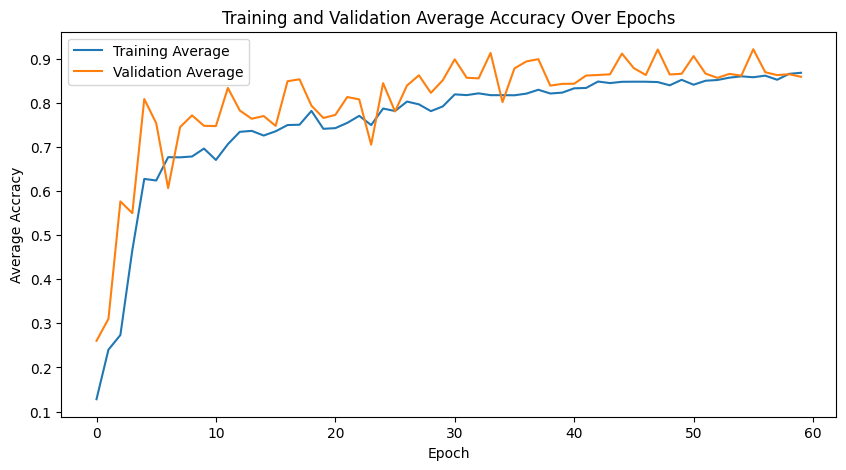

In [20]:
train_mean = [(entry['dice3']+entry['dice2']+entry['dice1'])/3 for entry in train_metrics_all]
val_mean = [(entry['dice3']+entry['dice2']+entry['dice1'])/3 for entry in val_metrics_all]
    
plt.figure(figsize=(10, 5))
plt.plot(train_mean, label='Training Average')
plt.plot(val_mean, label='Validation Average')

plt.xlabel('Epoch')
plt.ylabel('Average Accracy')
plt.title('Training and Validation Average Accuracy Over Epochs')
plt.legend()

plt.show()

### Testing by Sliding Window Inference

In [21]:
def calculate_metric_percase(pred, gt):
    dice = metric.binary.dc(pred, gt)
    jc = metric.binary.jc(pred, gt)
    hd = metric.binary.hd95(pred, gt)
    asd = metric.binary.asd(pred, gt)

    return dice, jc, hd, asd

def test_single_case(net, image, stride_xy, stride_z, patch_size, num_classes=1):
    print(image.shape)
    c, ww, hh, dd = image.shape

    sx = math.ceil((ww - patch_size[0]) / stride_xy) + 1
    sy = math.ceil((hh - patch_size[1]) / stride_xy) + 1
    sz = math.ceil((dd - patch_size[2]) / stride_z) + 1
    # print("{}, {}, {}".format(sx, sy, sz))
    score_map = np.zeros((num_classes, ) + image.shape[1:]).astype(np.float32)
    cnt = np.zeros(image.shape[1:]).astype(np.float32)

    for x in range(0, sx):
        xs = min(stride_xy*x, ww-patch_size[0])
        for y in range(0, sy):
            ys = min(stride_xy * y,hh-patch_size[1])
            for z in range(0, sz):
                zs = min(stride_z * z, dd-patch_size[2])
                test_patch = image[:,xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]]
                test_patch = np.expand_dims(test_patch,axis=0).astype(np.float32)
                test_patch = torch.from_numpy(test_patch).cuda()
                with torch.no_grad():
                    y1 = net(test_patch)
                    y = F.softmax(y1, dim=1)
                y = y.cpu().data.numpy()
                y = y[0,:,:,:,:]
                score_map[:, xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] \
                  = score_map[:, xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] + y
                cnt[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] \
                  = cnt[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] + 1
    score_map = score_map/np.expand_dims(cnt,axis=0)
    label_map = np.argmax(score_map, axis = 0)
    return label_map, score_map

def test_all_case(net, image_list, num_classes=2, patch_size=(112, 112, 80), stride_xy=18, stride_z=4, save_result=True, test_save_path=None, preproc_fn=None):
    total_metric = 0.0
    for ith,image_path in enumerate(image_list):
        h5f = h5py.File(image_path+'_mri_norm2.h5', 'r')
        image = h5f['image'][:]
        label = h5f['label'][:]
        label[label==4] = 3  # Change label from 4 to 3
        if preproc_fn is not None:
            image = preproc_fn(image)
        prediction, score_map = test_single_case(net, image, stride_xy, stride_z, patch_size, num_classes=num_classes)
        print(np.unique(prediction),np.unique(label))

        if np.sum(prediction)==0:
            single_metric = (0,0,0,0)
        else:
            single_metric = calculate_metric_percase(prediction, label[:])
        print('%02d,\t%.5f, %.5f, %.5f, %.5f' % (ith, single_metric[0], single_metric[1], single_metric[2], single_metric[3]))
        total_metric += np.asarray(single_metric)

        if save_result:
            nib.save(nib.Nifti1Image(prediction.astype(np.float32), np.eye(4)), test_save_path + "%02d_pred.nii.gz"%(ith))
            # image only saves one modality
            nib.save(nib.Nifti1Image(image[0].astype(np.float32), np.eye(4)), test_save_path + "%02d_img.nii.gz"%(ith))
            nib.save(nib.Nifti1Image(label[:].astype(np.float32), np.eye(4)), test_save_path + "%02d_gt.nii.gz"%(ith))
    avg_metric = total_metric / len(image_list)
    print('average metric is {}'.format(avg_metric))

    return avg_metric

In [22]:
!mkdir predictions
!mkdir predictions/unet

In [23]:
# gc.collect()
# torch.cuda.empty_cache()

In [24]:
test_save_path = './predictions/unet/'
save_mode_path = args.weights

if args.model == 'unet':
    net = UNet(in_channels=4,num_classes=4)
else:
    net = AttentionUNet(in_channels=4, num_classes=4)
counter = 0
for p in net.parameters():
    counter += p.numel()
print('Param', counter)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)
net = net.to(device)

net.load_state_dict(torch.load(save_mode_path)['model'])
print("init weight from {}".format(save_mode_path))
net.eval()

with open(args.test_txt, 'r') as f:
    image_list = [os.path.join(args.data_path, x.strip()) for x in f.readlines()]
print('Total number of images is', len(image_list))
# print(image_list[0])

# sliding_window_inference
avg_metric = test_all_case(net, image_list, num_classes=4,
                            patch_size=(160,160,128), stride_xy=32, stride_z=16,
                            save_result=True,test_save_path=test_save_path)   

Param 6438424
init weight from ./results/UNet.pth
Total number of images is 13
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
00,	0.94353, 0.89309, 6.40312, 0.44886
(4, 240, 240, 155)
[0 2 3] [0 2 3]
01,	0.95085, 0.90630, 1.41421, 0.55729
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
02,	0.97379, 0.94891, 1.00000, 0.37893
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
03,	0.94602, 0.89757, 1.41421, 0.91799
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
04,	0.88693, 0.79682, 5.38516, 2.11129
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
05,	0.63328, 0.46336, 21.40093, 1.87803
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
06,	0.60761, 0.43638, 14.86607, 1.99890
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
07,	0.89198, 0.80502, 2.82843, 0.44384
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
08,	0.96338, 0.92935, 2.23607, 0.81787
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
09,	0.93561, 0.87901, 2.23607, 0.50600
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
10,	0.86980, 0.76960, 4.69042, 1.60783
(4, 240, 240, 155)
[0 1 2 3] [0 1 2 3]
11,	0.89768, 0.81435, 4.89

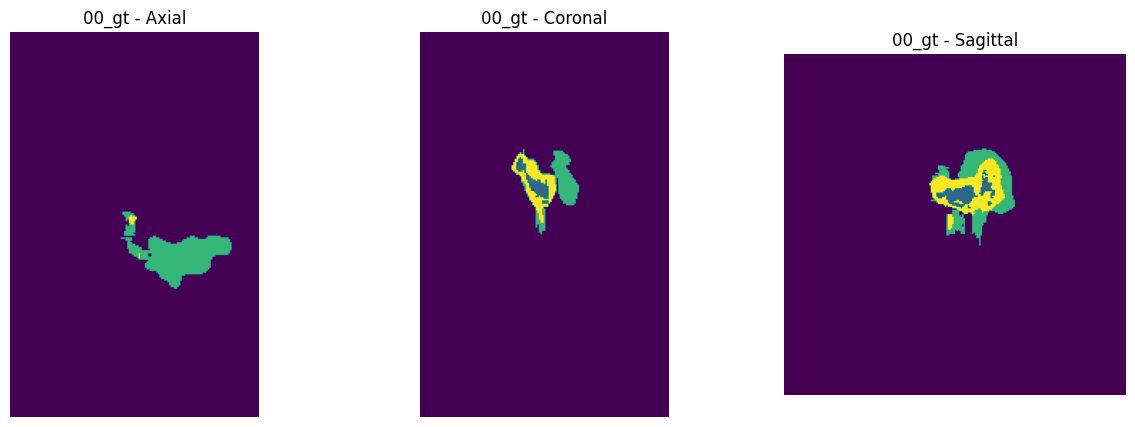

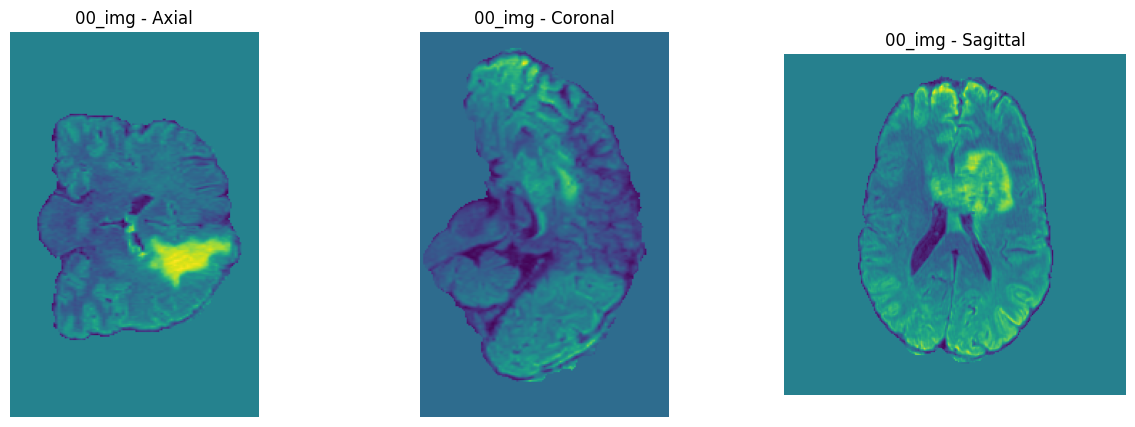

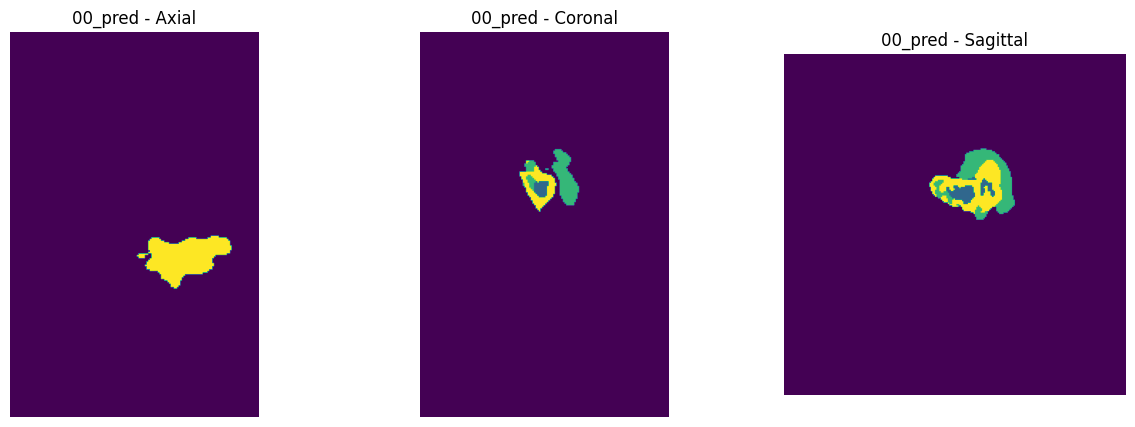

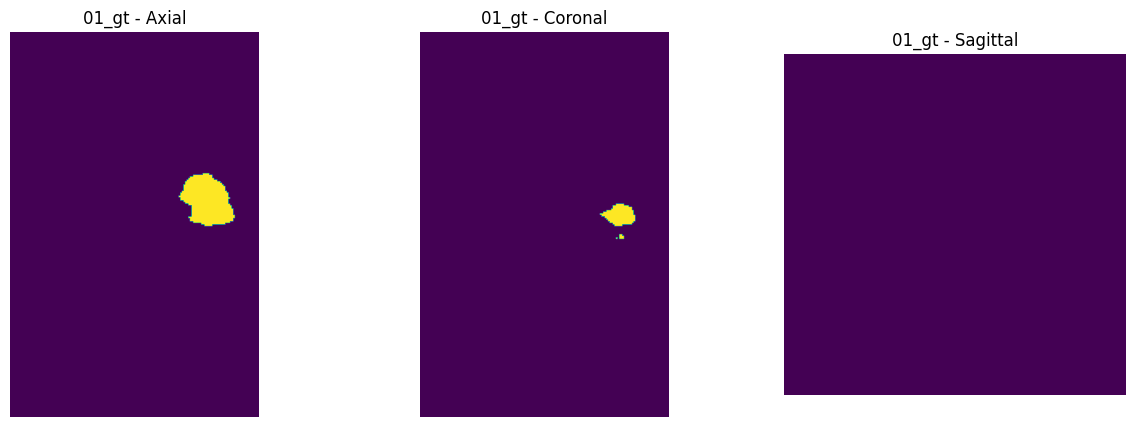

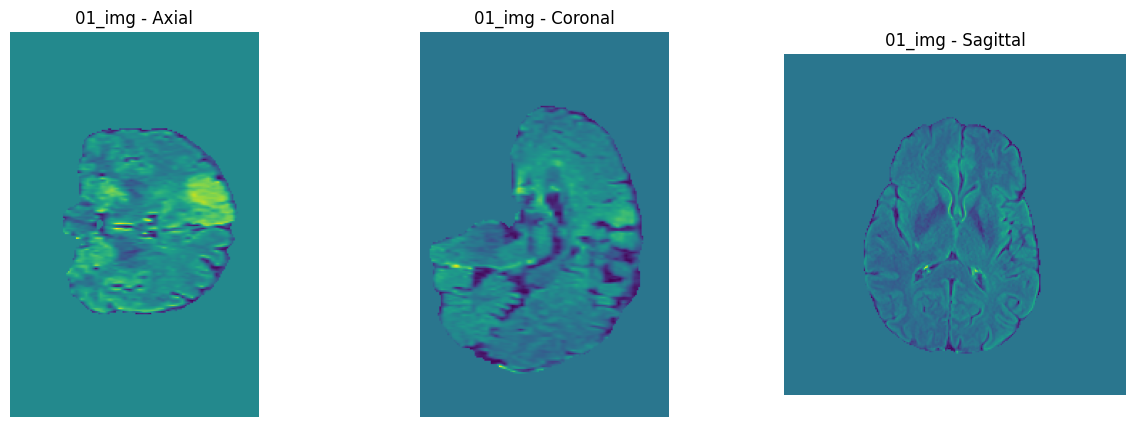

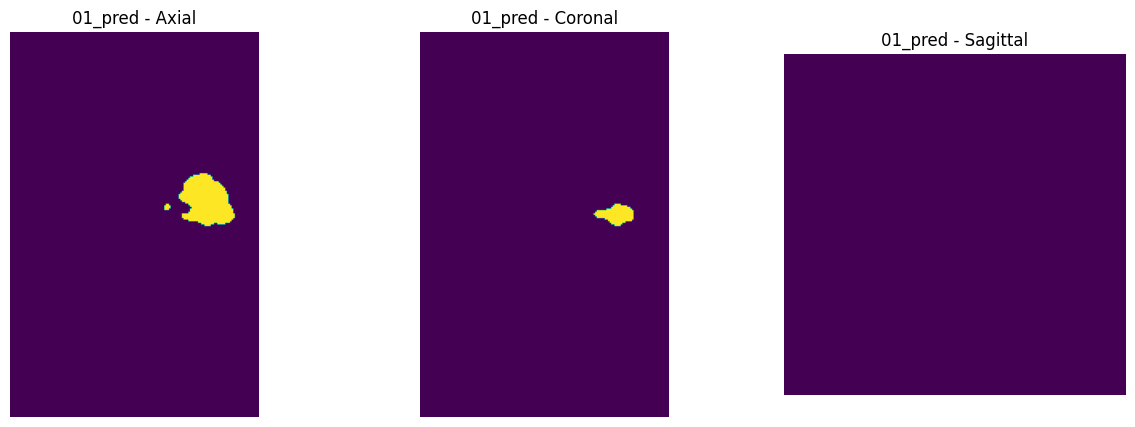

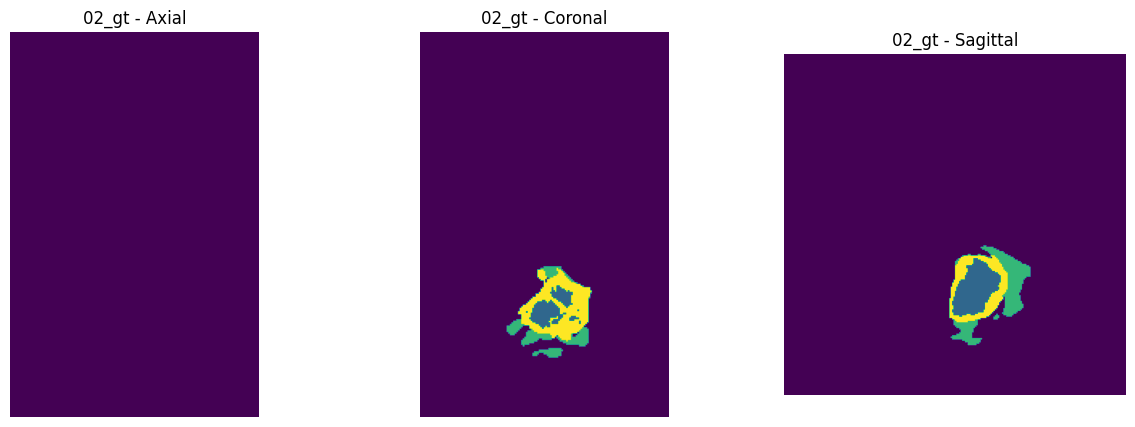

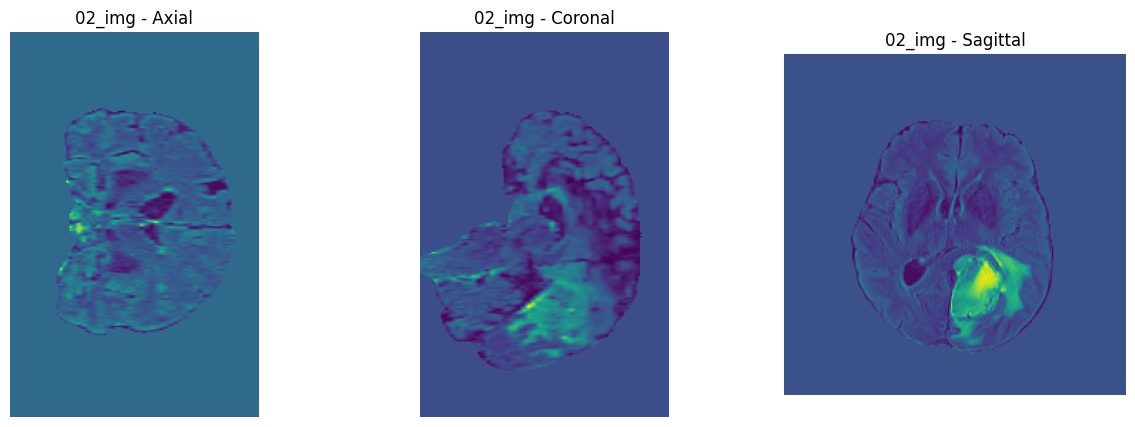

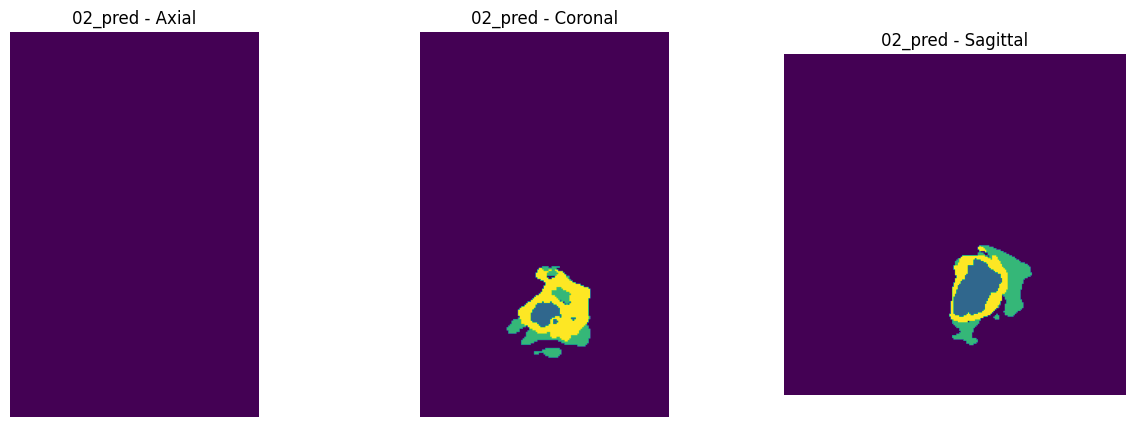

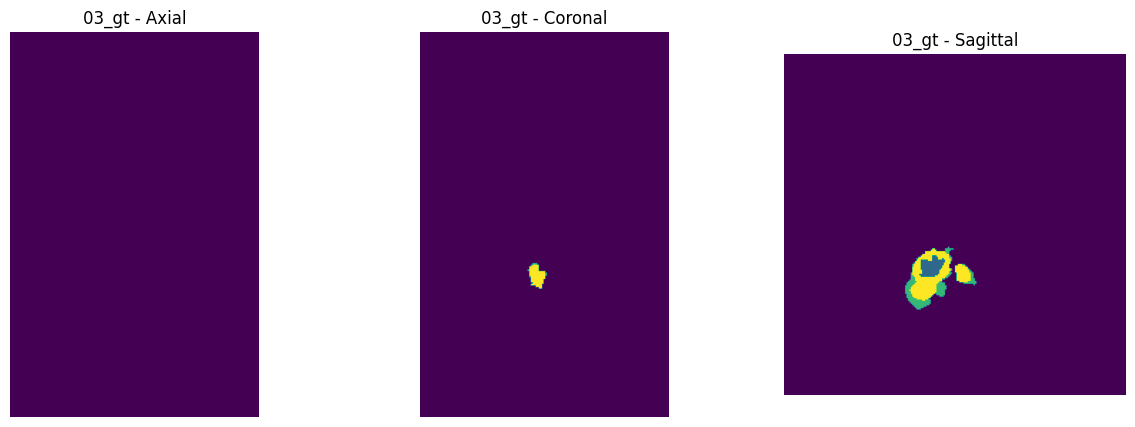

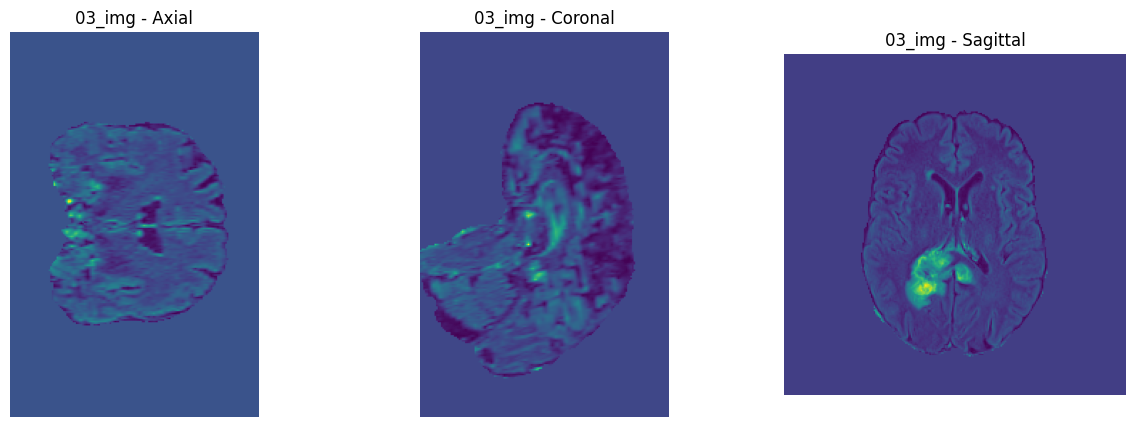

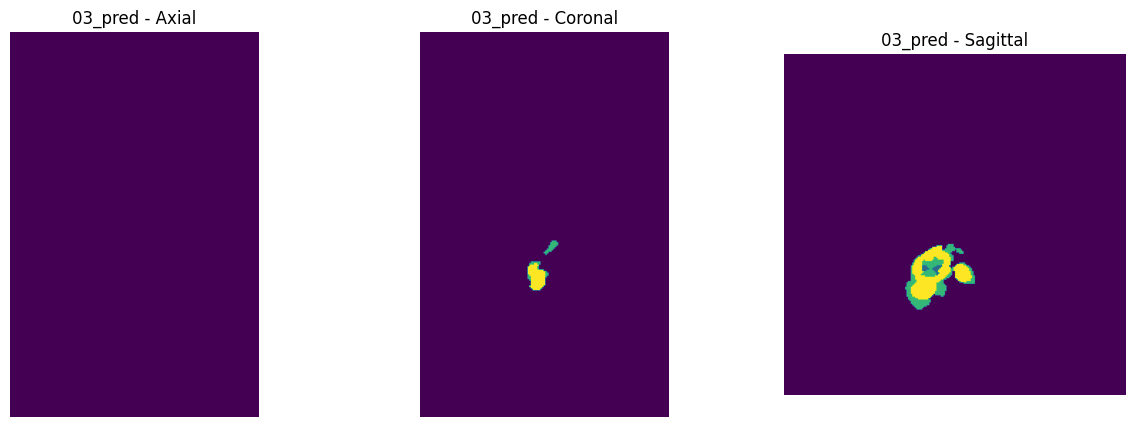

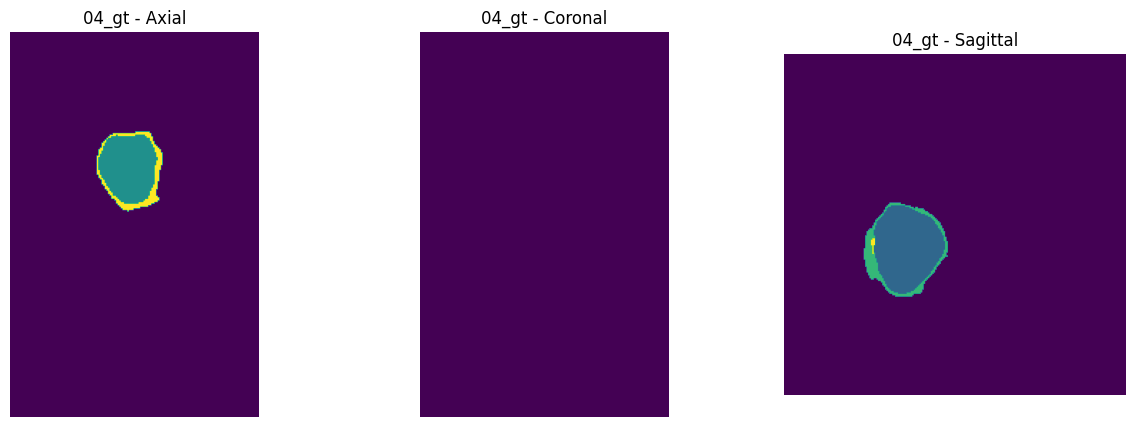

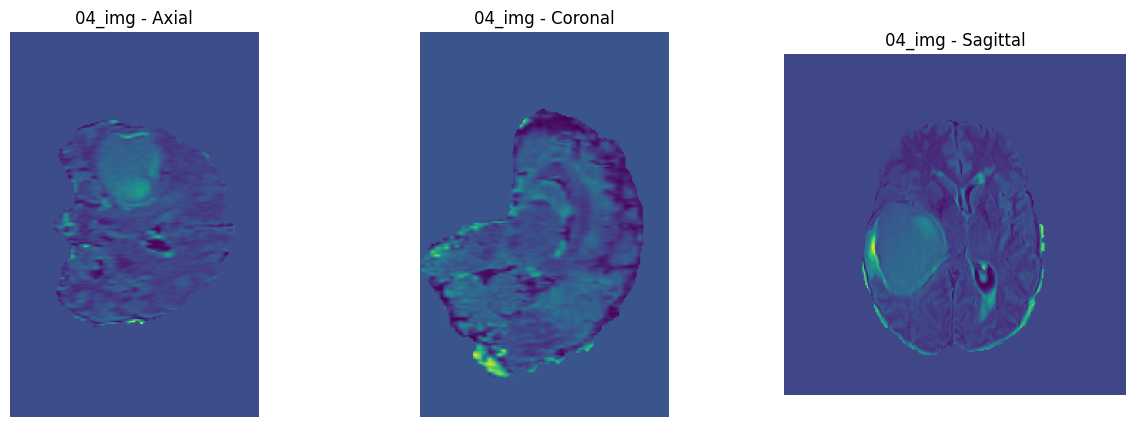

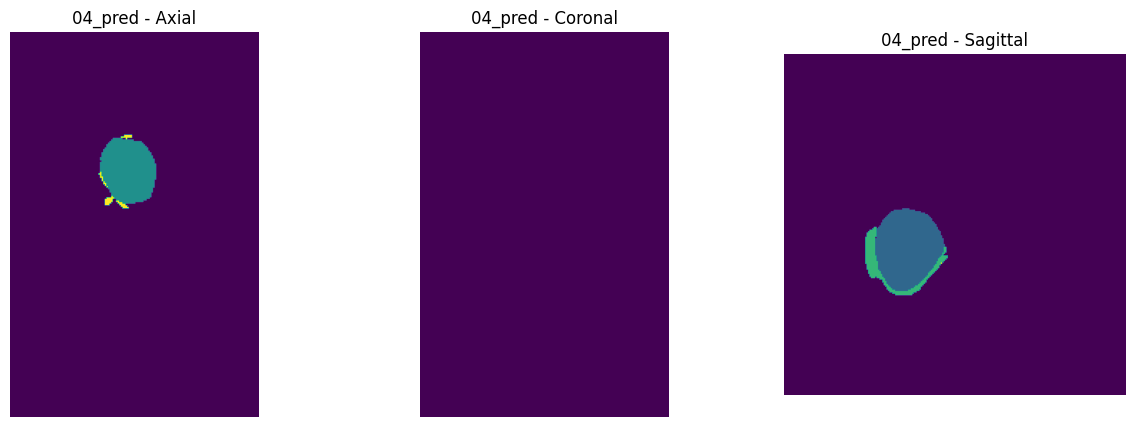

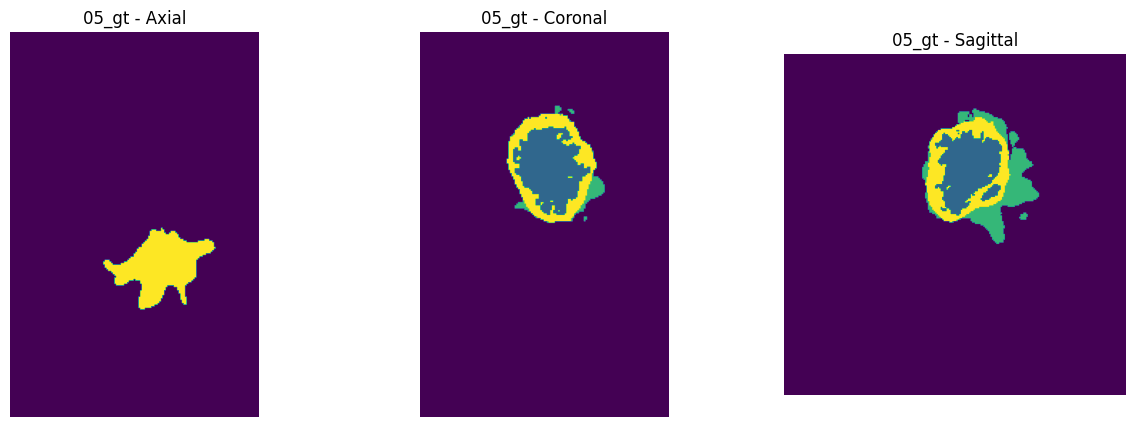

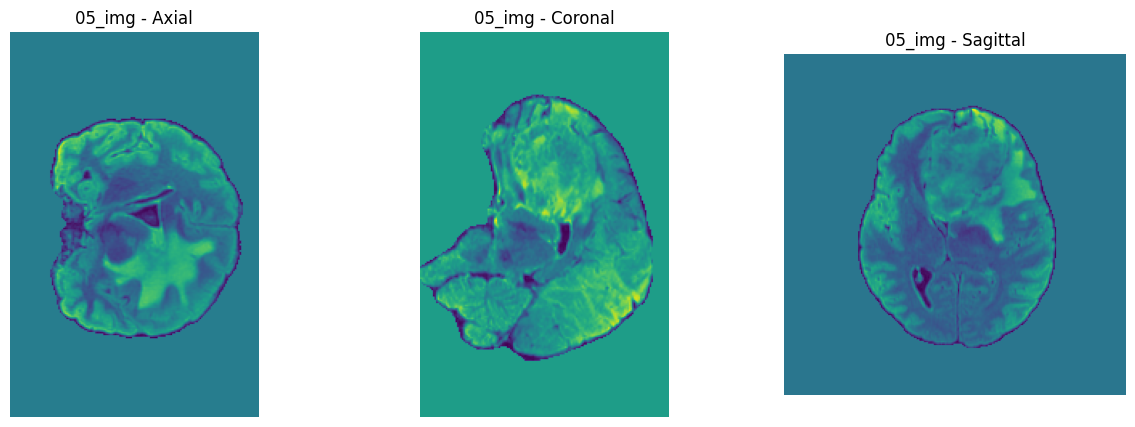

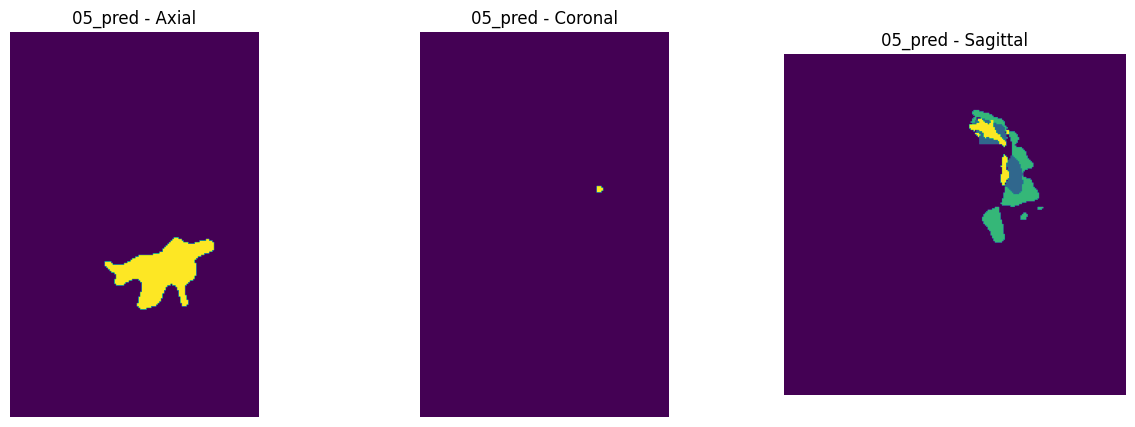

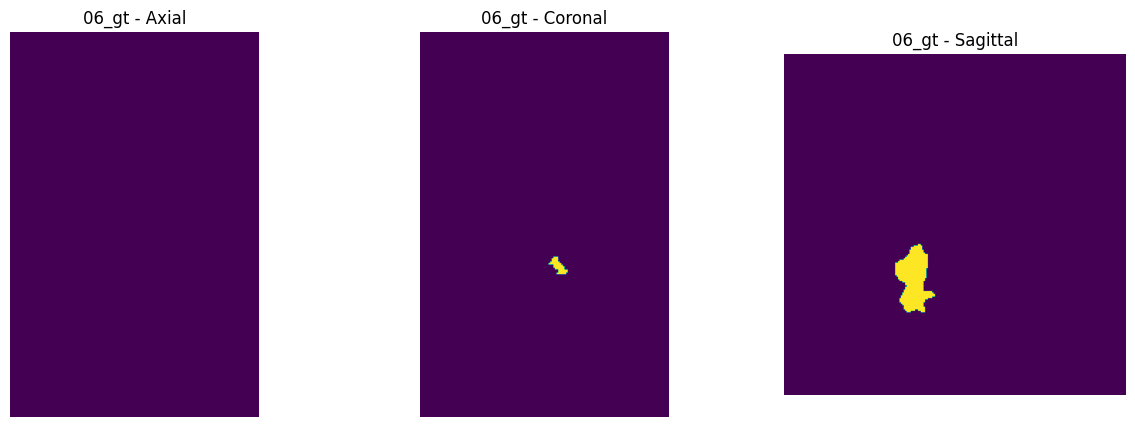

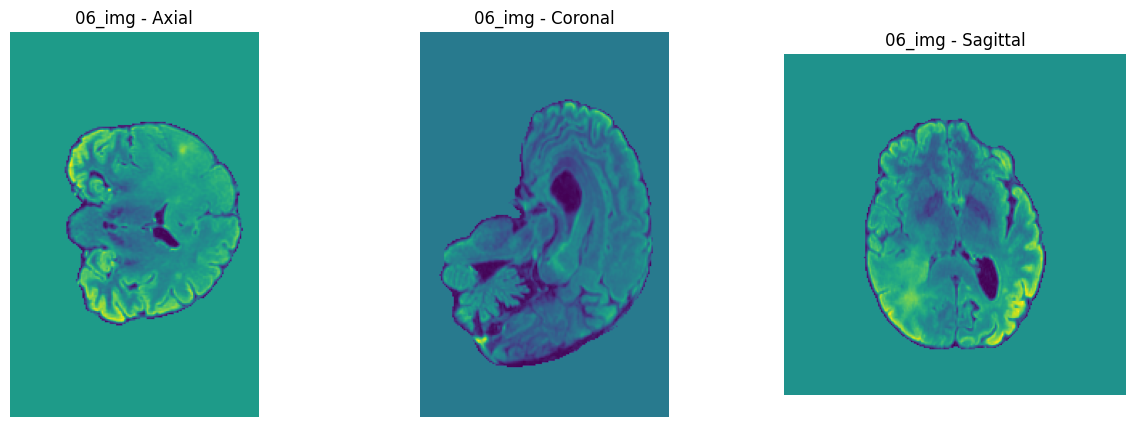

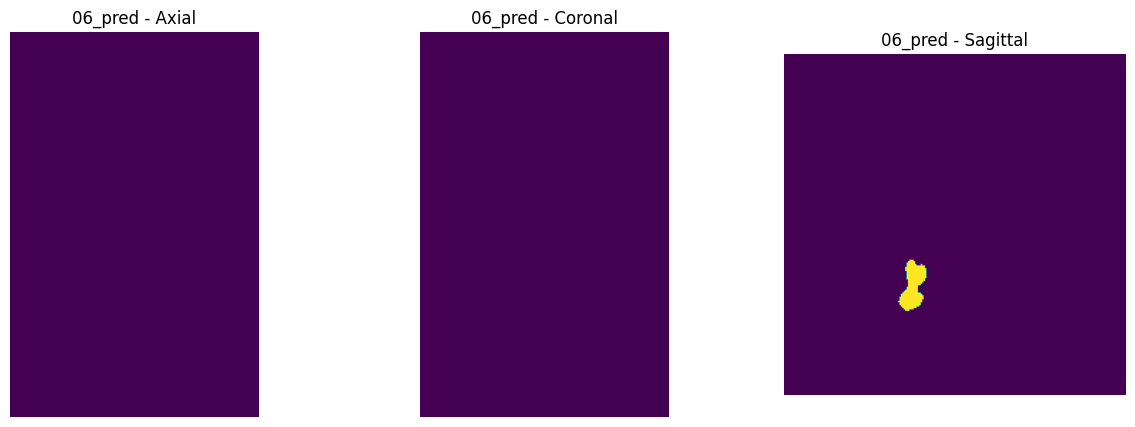

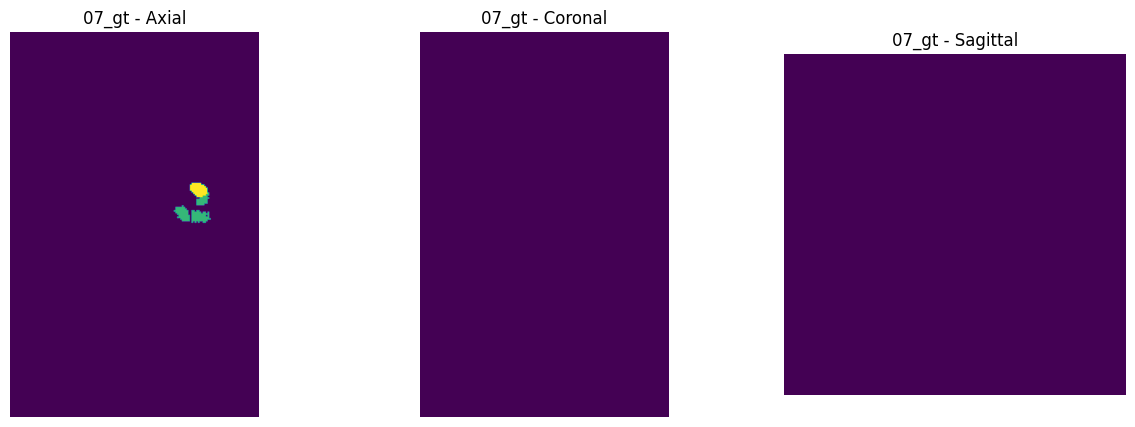

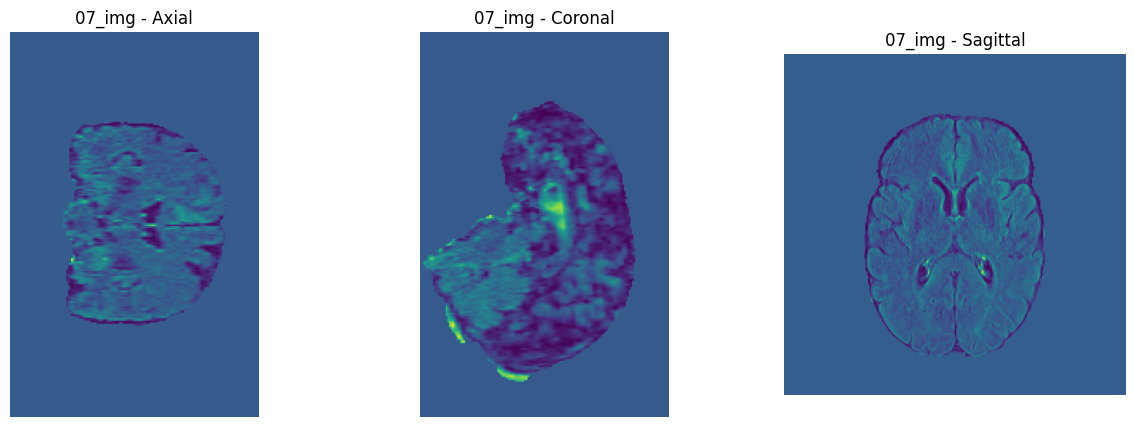

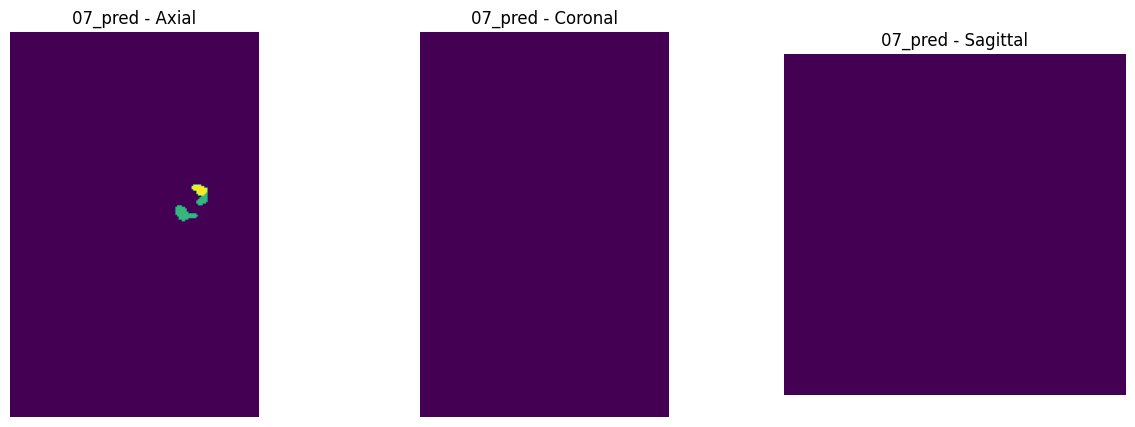

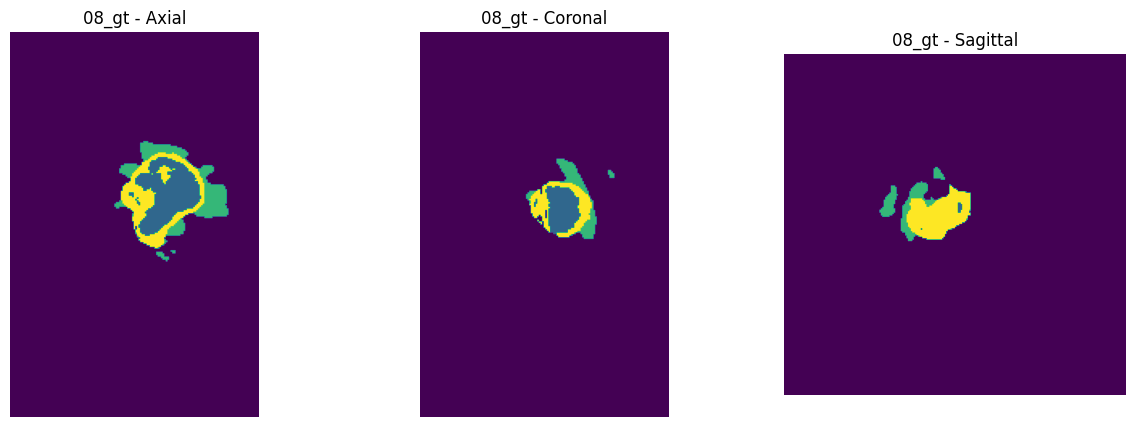

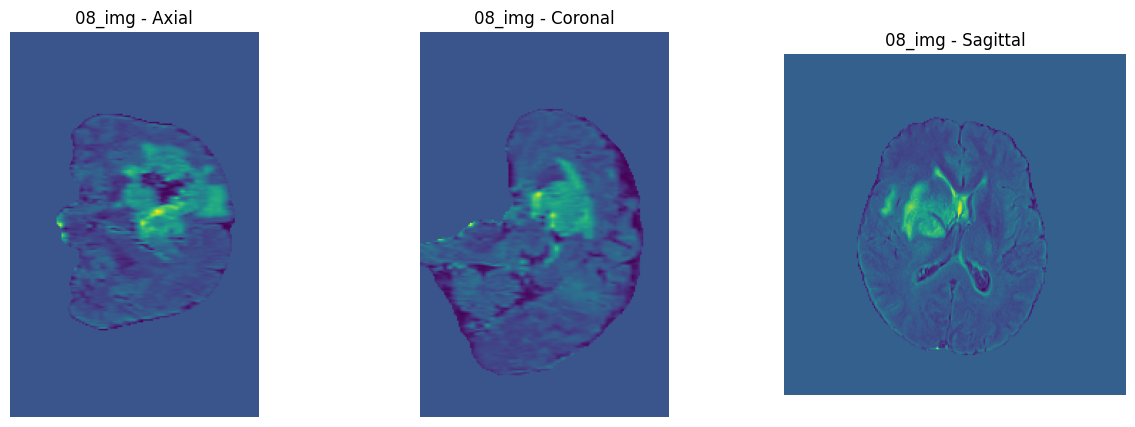

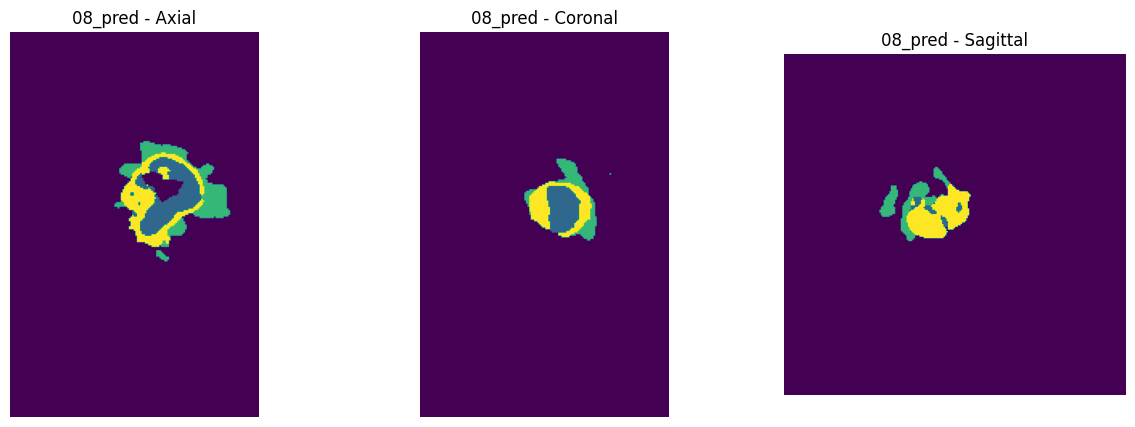

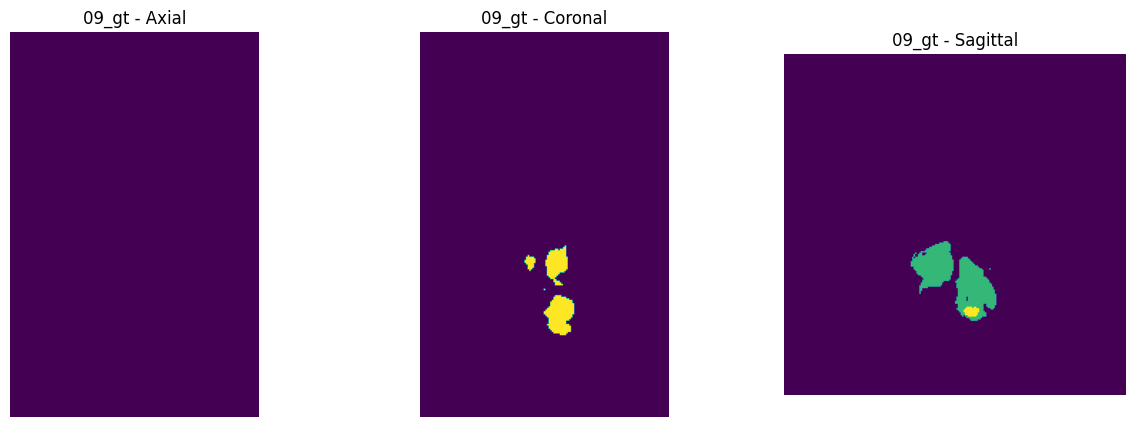

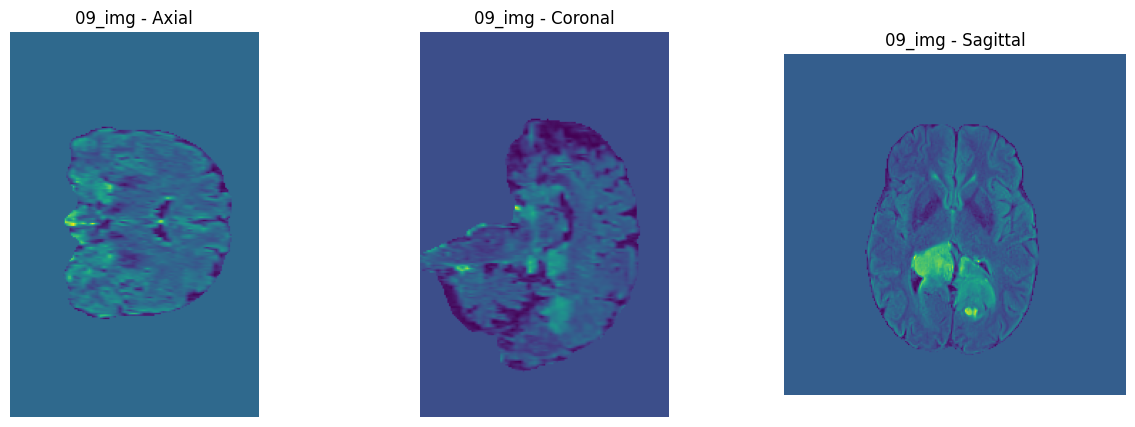

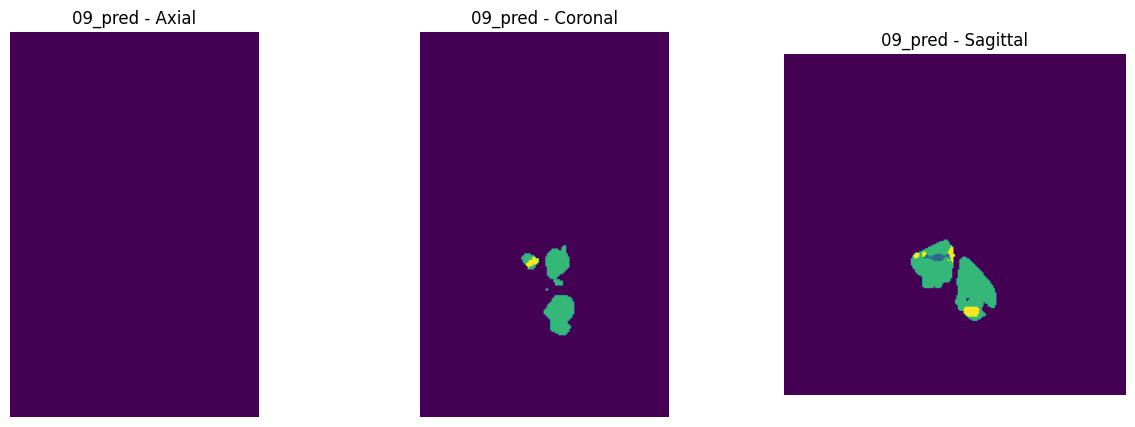

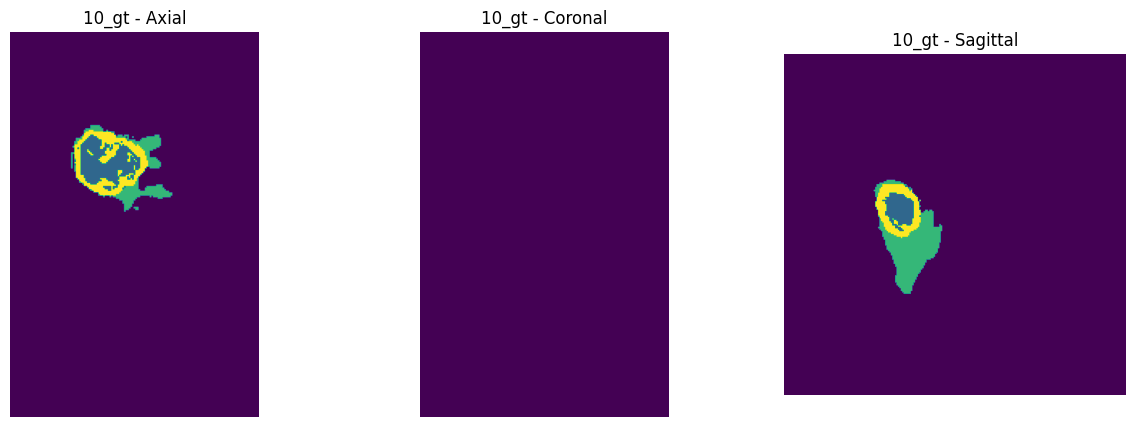

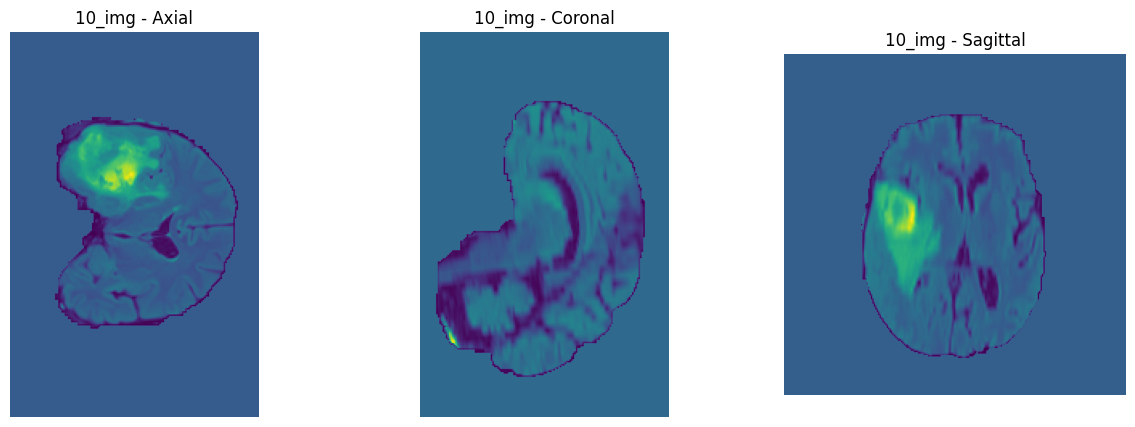

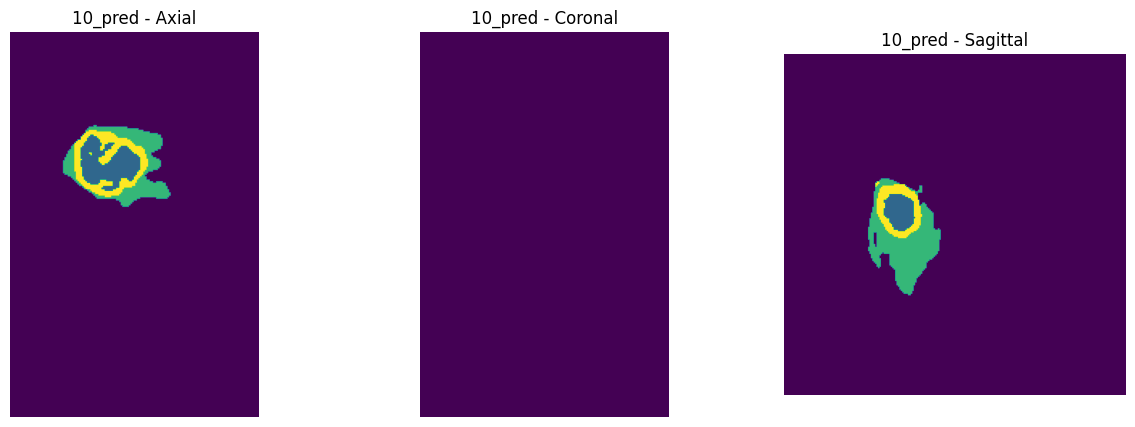

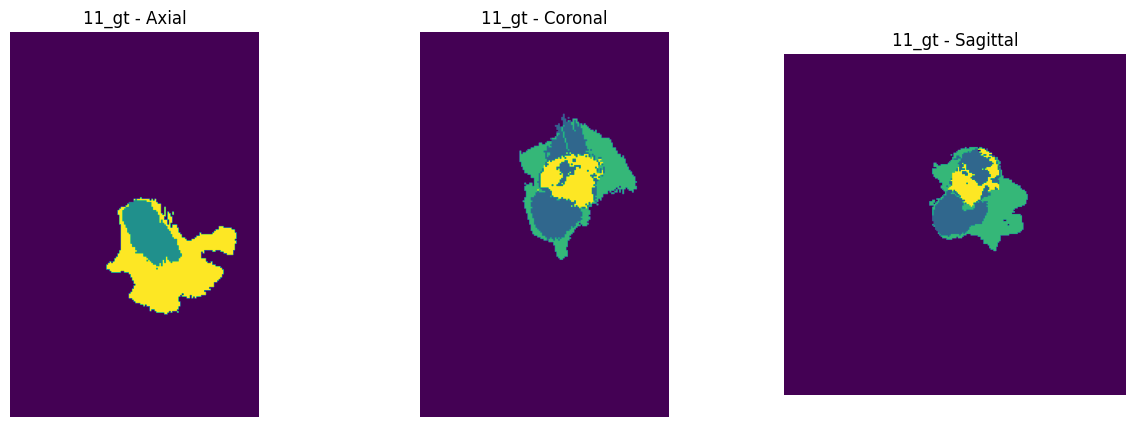

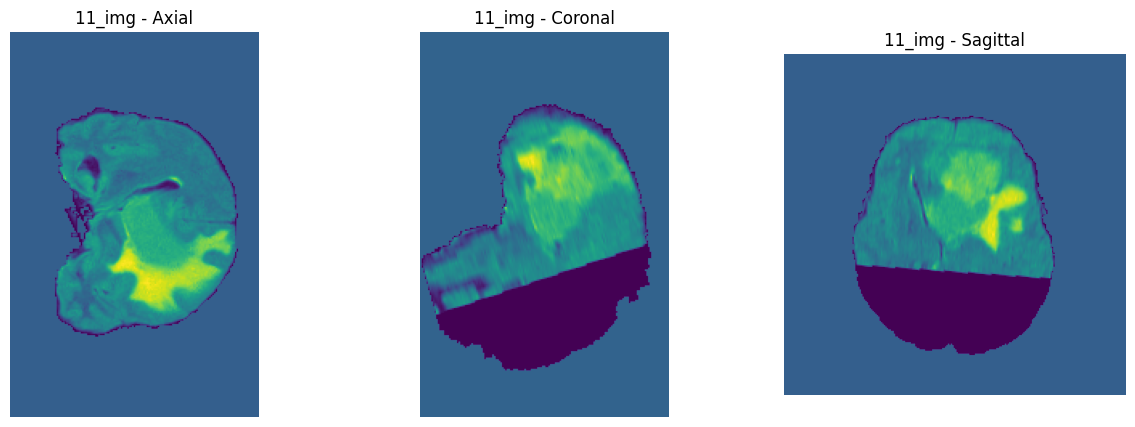

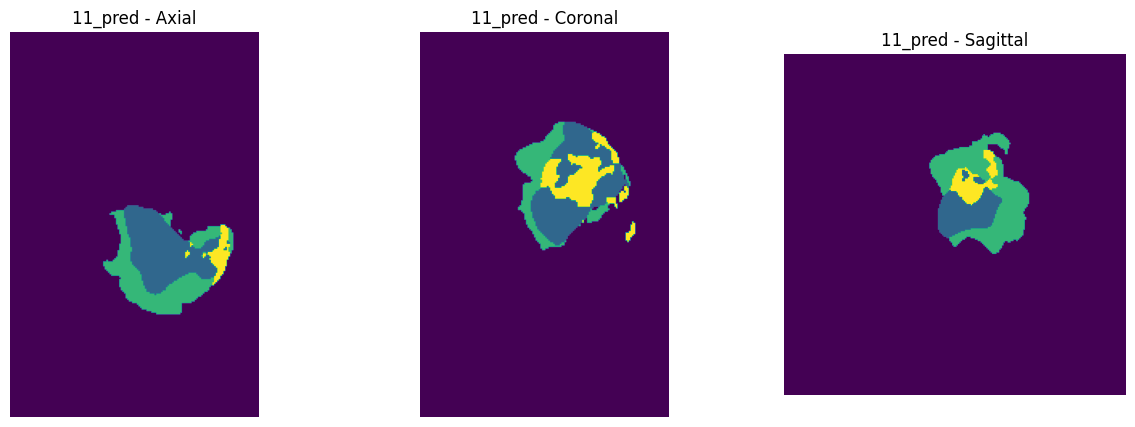

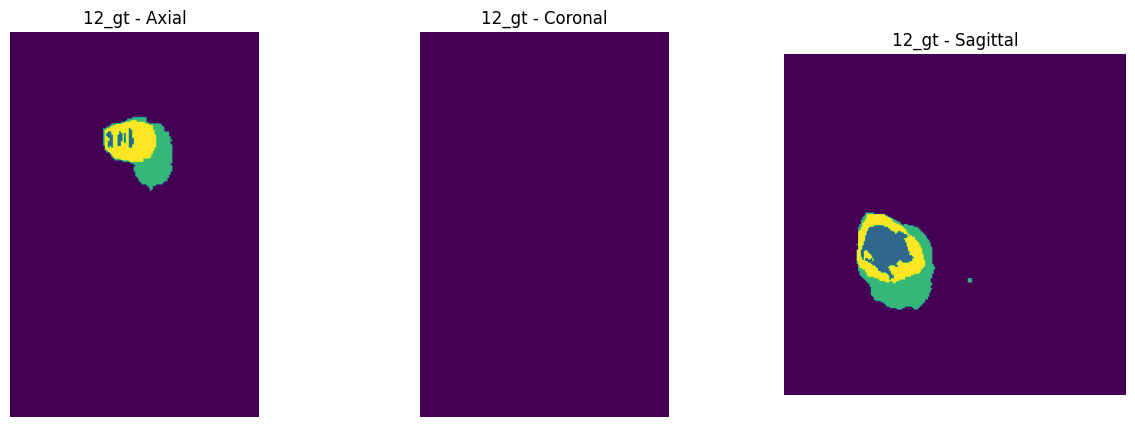

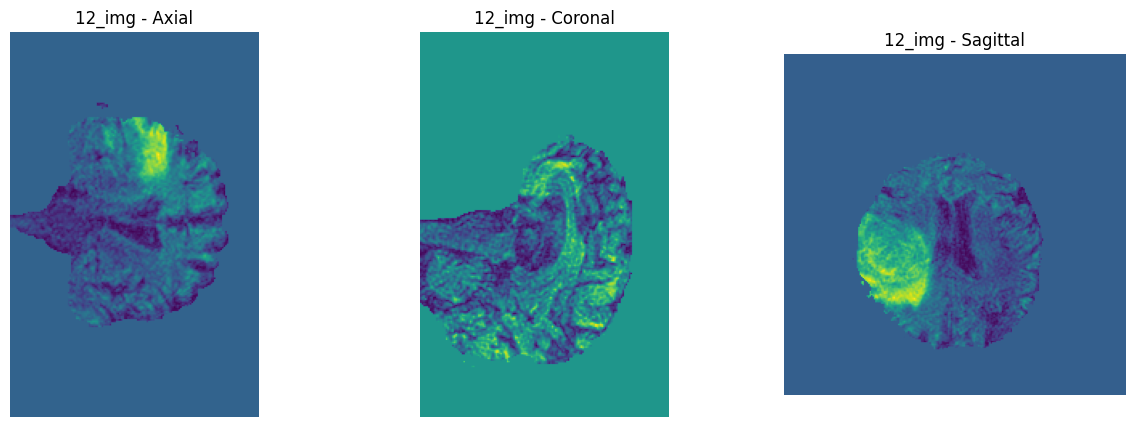

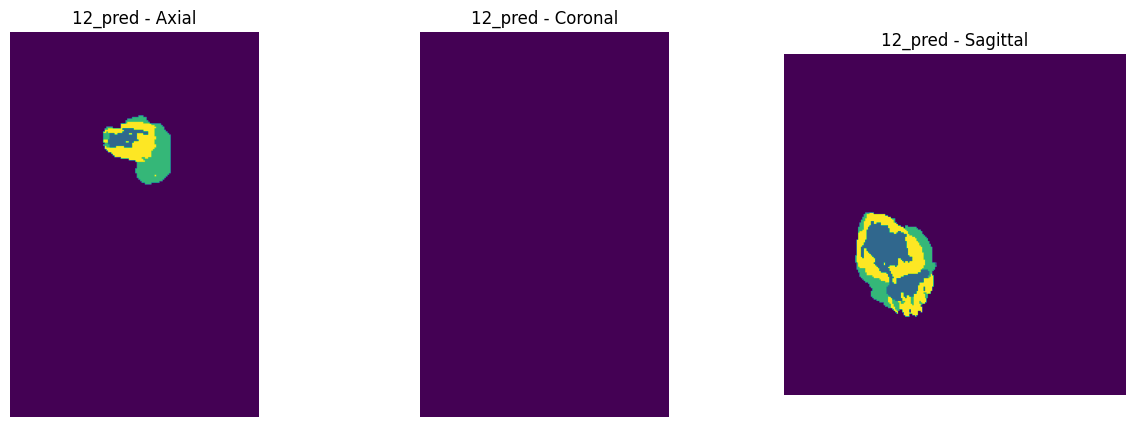

In [25]:
def display_nifti(file_path, title):
    img = nib.load(file_path)
    data = img.get_fdata()
    
    # Display the middle slice of each dimension
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(data[data.shape[0] // 2, :, :], cmap='viridis')
    axes[0].set_title(f'{title} - Axial')
    axes[0].axis('off')
    
    axes[1].imshow(data[:, data.shape[1] // 2, :], cmap='viridis')
    axes[1].set_title(f'{title} - Coronal')
    axes[1].axis('off')
    
    axes[2].imshow(data[:, :, data.shape[2] // 2], cmap='viridis')
    axes[2].set_title(f'{title} - Sagittal')
    axes[2].axis('off')
    plt.show()

# Loop through all files and visualize them
for file_name in sorted(os.listdir(test_save_path)):
    if file_name.endswith('.nii.gz'):
        file_path = os.path.join(test_save_path, file_name)
        title = file_name.split('.')[0]
        display_nifti(file_path, title)

In [26]:
shutil.make_archive('./attention_aunet0510_lr002', 'zip', test_save_path)

'/kaggle/working/attention_aunet0510_lr002.zip'